In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings, gc, joblib
warnings.filterwarnings('ignore')
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import probplot
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, f_classif
from subprocess import call
from IPython.display import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df = pd.read_csv('Weather Data.csv')
df.head()

Date/Time  Temp_C  Dew Point Temp_C  Rel Hum_%  Wind Speed_km/h  \
0  1/1/2012 0:00    -1.8              -3.9         86                4   
1  1/1/2012 1:00    -1.8              -3.7         87                4   
2  1/1/2012 2:00    -1.8              -3.4         89                7   
3  1/1/2012 3:00    -1.5              -3.2         88                6   
4  1/1/2012 4:00    -1.5              -3.3         88                7   

   Visibility_km  Press_kPa               Weather  
0            8.0     101.24                   Fog  
1            8.0     101.24                   Fog  
2            4.0     101.26  Freezing Drizzle,Fog  
3            4.0     101.27  Freezing Drizzle,Fog  
4            4.8     101.23                   Fog

In [3]:
df.shape

(8784, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date/Time         8784 non-null   object 
 1   Temp_C            8784 non-null   float64
 2   Dew Point Temp_C  8784 non-null   float64
 3   Rel Hum_%         8784 non-null   int64  
 4   Wind Speed_km/h   8784 non-null   int64  
 5   Visibility_km     8784 non-null   float64
 6   Press_kPa         8784 non-null   float64
 7   Weather           8784 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 549.1+ KB


In [5]:
df.describe()

Temp_C  Dew Point Temp_C    Rel Hum_%  Wind Speed_km/h  \
count  8784.000000       8784.000000  8784.000000      8784.000000   
mean      8.798144          2.555294    67.431694        14.945469   
std      11.687883         10.883072    16.918881         8.688696   
min     -23.300000        -28.500000    18.000000         0.000000   
25%       0.100000         -5.900000    56.000000         9.000000   
50%       9.300000          3.300000    68.000000        13.000000   
75%      18.800000         11.800000    81.000000        20.000000   
max      33.000000         24.400000   100.000000        83.000000   

       Visibility_km    Press_kPa  
count    8784.000000  8784.000000  
mean       27.664447   101.051623  
std        12.622688     0.844005  
min         0.200000    97.520000  
25%        24.100000   100.560000  
50%        25.000000   101.070000  
75%        25.000000   101.590000  
max        48.300000   103.650000

In [6]:
df.isna().sum()

Date/Time           0
Temp_C              0
Dew Point Temp_C    0
Rel Hum_%           0
Wind Speed_km/h     0
Visibility_km       0
Press_kPa           0
Weather             0
dtype: int64

In [7]:
df.duplicated().sum()

0

## Exploratory Data Analysis

Skewness of Temp_C: -0.17766634898276745
Kurtosis of Temp_C: -0.9155567505542197


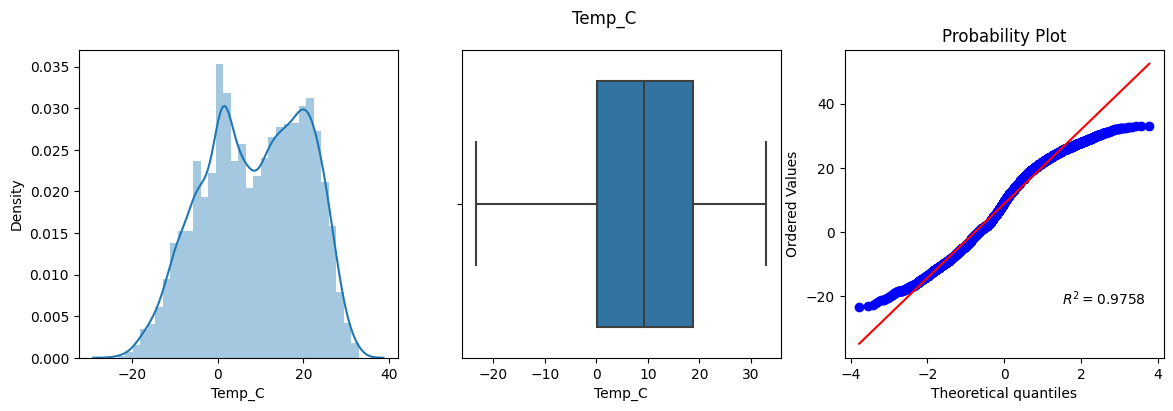

Skewness of Dew Point Temp_C: -0.31843338608156885
Kurtosis of Dew Point Temp_C: -0.8157875944814732


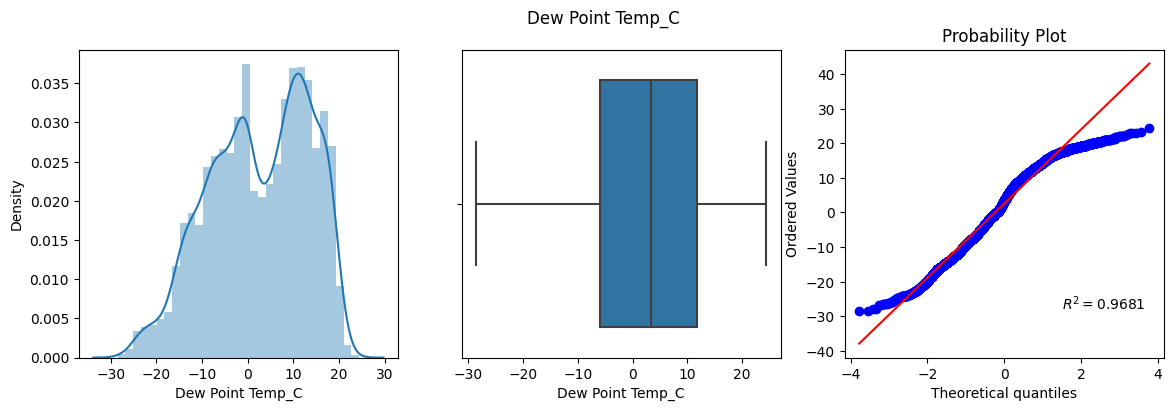

Skewness of Rel Hum_%: -0.32383026939145887
Kurtosis of Rel Hum_%: -0.5529352317433536


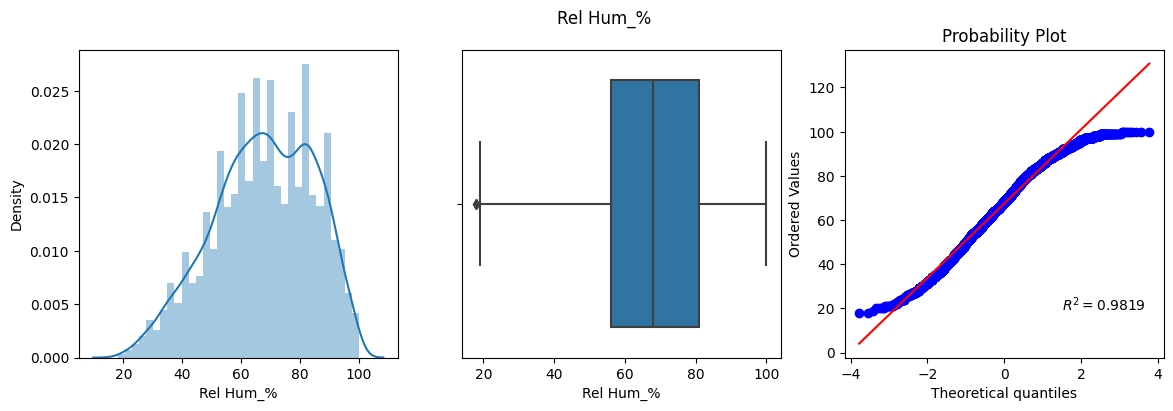

Skewness of Wind Speed_km/h: 0.8713742625776061
Kurtosis of Wind Speed_km/h: 1.5407125247939306


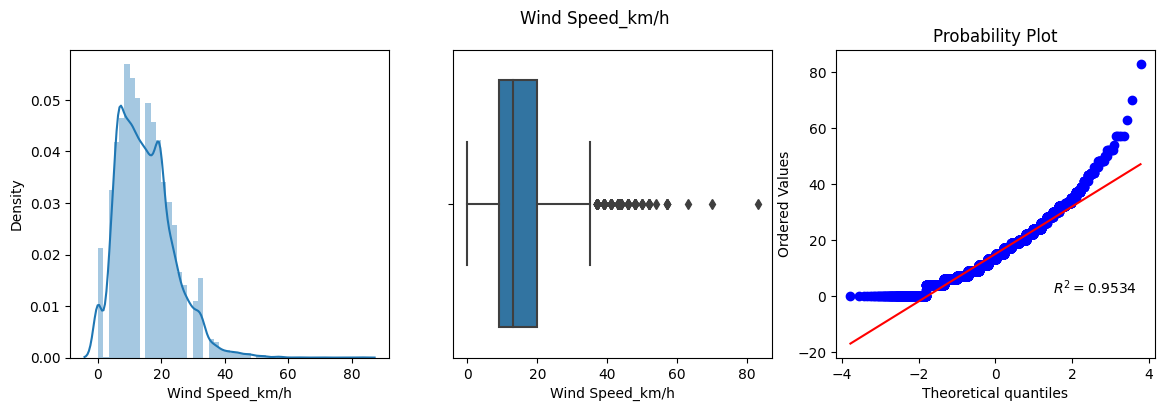

Skewness of Visibility_km: 0.41336159676061063
Kurtosis of Visibility_km: -0.35103132005897164


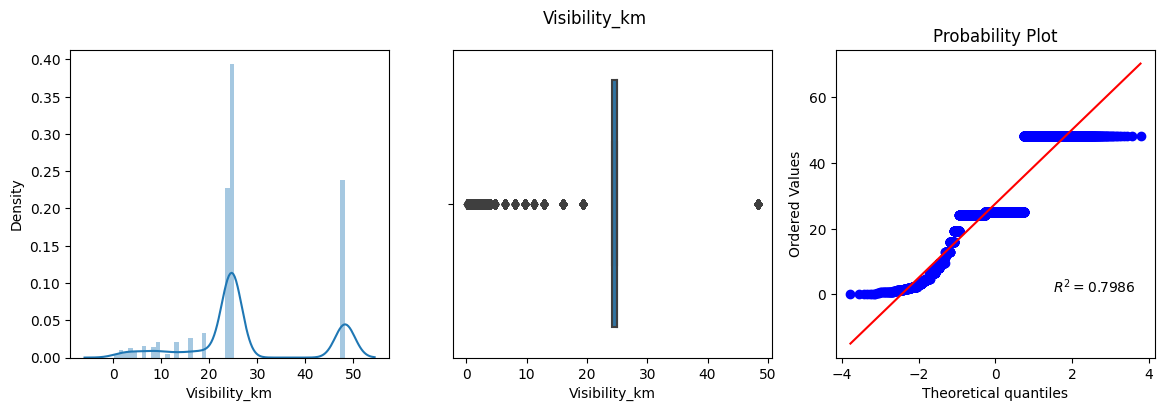

Skewness of Press_kPa: -0.22992511978286803
Kurtosis of Press_kPa: 0.7144508236613349


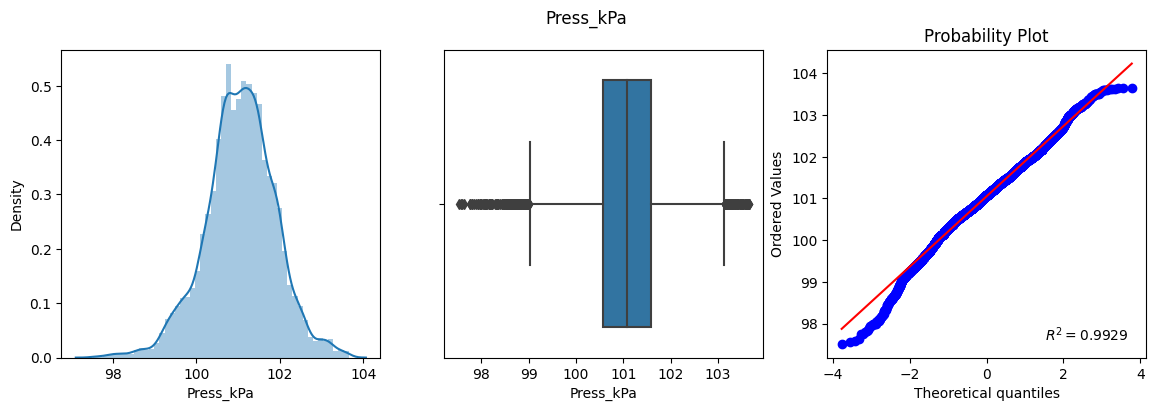

In [8]:
for col in df.select_dtypes(np.number).columns:
    plt.figure(figsize=(14,4))
    print(f"Skewness of {col}:",df[col].skew())
    print(f"Kurtosis of {col}:",df[col].kurtosis())
    plt.subplot(131)
    sns.distplot(df[col])
    plt.subplot(132)
    sns.boxplot(df[col])
    plt.subplot(133)
    probplot(df[col],dist='norm',rvalue=True,plot=plt)
    plt.suptitle(col)
    plt.show()

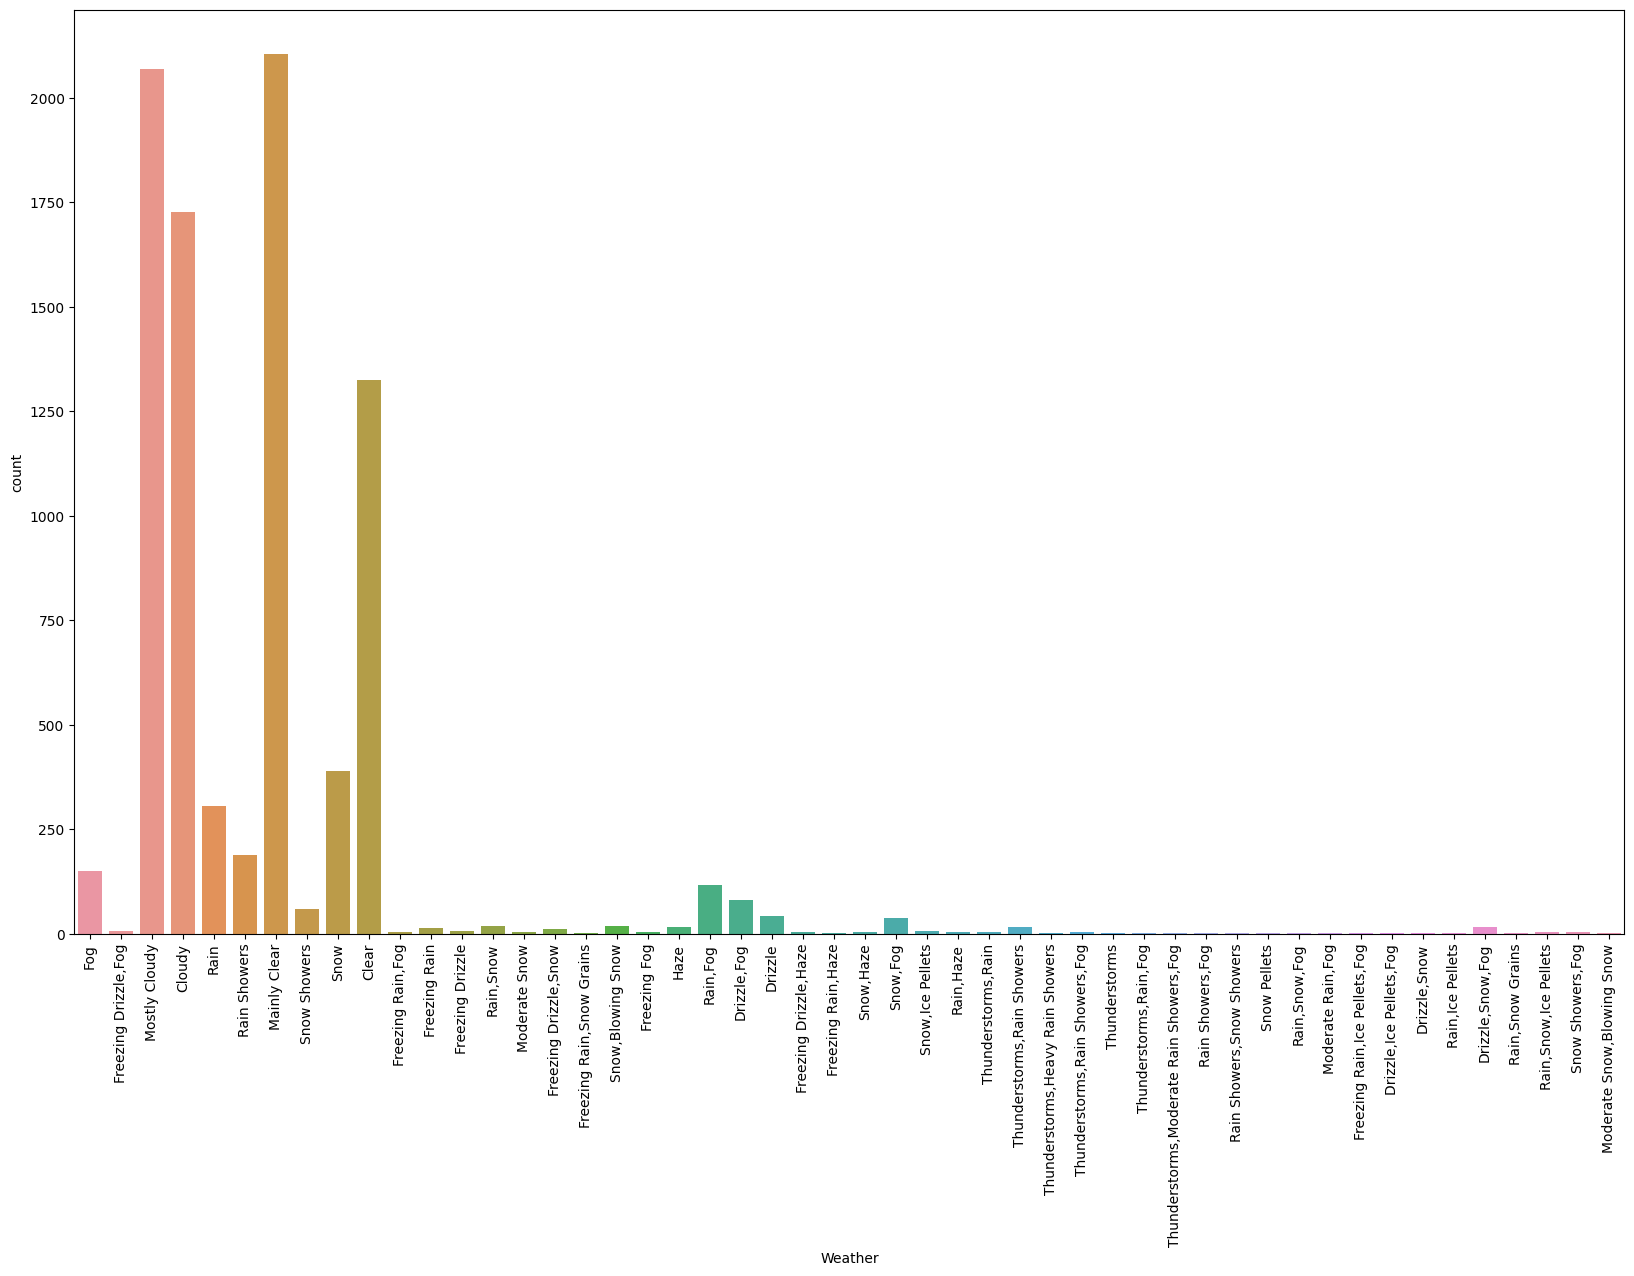

10763

In [9]:
plt.figure(figsize=(20,12))
fig = sns.countplot(df['Weather'])
plt.xticks(rotation=90)
plt.show(fig)
plt.close('all')
del fig
gc.collect()

In [10]:
df.Weather.nunique()

50

In [11]:
df.Weather.value_counts()

Mainly Clear                               2106
Mostly Cloudy                              2069
Cloudy                                     1728
Clear                                      1326
Snow                                        390
Rain                                        306
Rain Showers                                188
Fog                                         150
Rain,Fog                                    116
Drizzle,Fog                                  80
Snow Showers                                 60
Drizzle                                      41
Snow,Fog                                     37
Snow,Blowing Snow                            19
Rain,Snow                                    18
Thunderstorms,Rain Showers                   16
Haze                                         16
Drizzle,Snow,Fog                             15
Freezing Rain                                14
Freezing Drizzle,Snow                        11
Freezing Drizzle                        

In [12]:
categories = ['Clear','Cloudy','Snow','Rain','Drizzle','Fog','Thunderstorms','Haze']

df.Weather.replace(to_replace='Mainly Clear',value='Clear',inplace=True)
df.Weather.replace(to_replace='Mostly Cloudy',value='Cloudy',inplace=True)
df.Weather.replace(to_replace=['Snow Showers','Snow,Blowing Snow','Rain,Snow','Freezing Drizzle,Snow','Freezing Rain,Snow Grains','Snow,Ice Pellets','Moderate Snow','Rain,Snow,Ice Pellets','Drizzle,Snow','Rain Showers,Snow Showers','Moderate Snow,Blowing Snow','Snow Pellets','Rain,Snow Grains'],value='Snow',inplace=True)
df.Weather.replace(to_replace=['Rain Showers','Freezing Rain','Rain,Ice Pellets'],value='Rain',inplace=True)
df.Weather.replace(to_replace='Freezing Drizzle',value='Drizzle',inplace=True)
df.Weather.replace(to_replace=['Rain,Fog','Drizzle,Fog','Snow,Fog','Drizzle,Snow,Fog','Freezing Drizzle,Fog','Freezing Fog','Snow Showers,Fog','Freezing Rain,Fog','Thunderstorms,Rain Showers,Fog','Rain Showers,Fog','Thunderstorms,Moderate Rain Showers,Fog','Rain,Snow,Fog','Moderate Rain,Fog','Freezing Rain,Ice Pellets,Fog','Drizzle,Ice Pellets,Fog','Thunderstorms,Rain,Fog'],value='Fog',inplace=True)
df.Weather.replace(to_replace=['Thunderstorms,Rain Showers','Thunderstorms,Rain','Thunderstorms,Heavy Rain Showers'],value='Thunderstorms',inplace=True)
df.Weather.replace(to_replace=['Snow,Haze','Rain,Haze','Freezing Drizzle,Haze','Freezing Rain,Haze',],value='Haze',inplace=True)

In [13]:
df.Weather.value_counts()

Cloudy           3797
Clear            3432
Snow              521
Rain              509
Fog               426
Drizzle            48
Haze               29
Thunderstorms      22
Name: Weather, dtype: int64

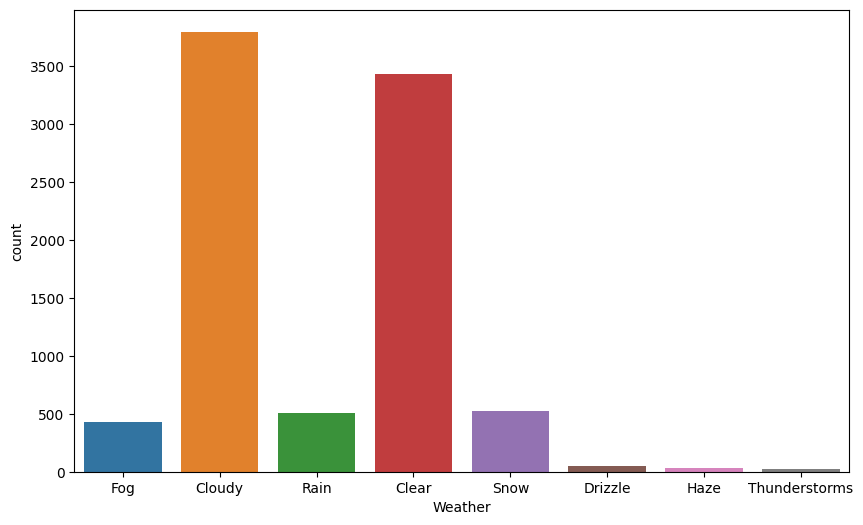

3949

In [14]:
plt.figure(figsize=(10,6))
fig = sns.countplot(df['Weather'])
plt.show(fig)
plt.close('all')
del fig
gc.collect()

This is clearly an imbalanced dataset with 'Cloudy' and 'Clear' being the majority classes and the remaining ones being the minority classes. 

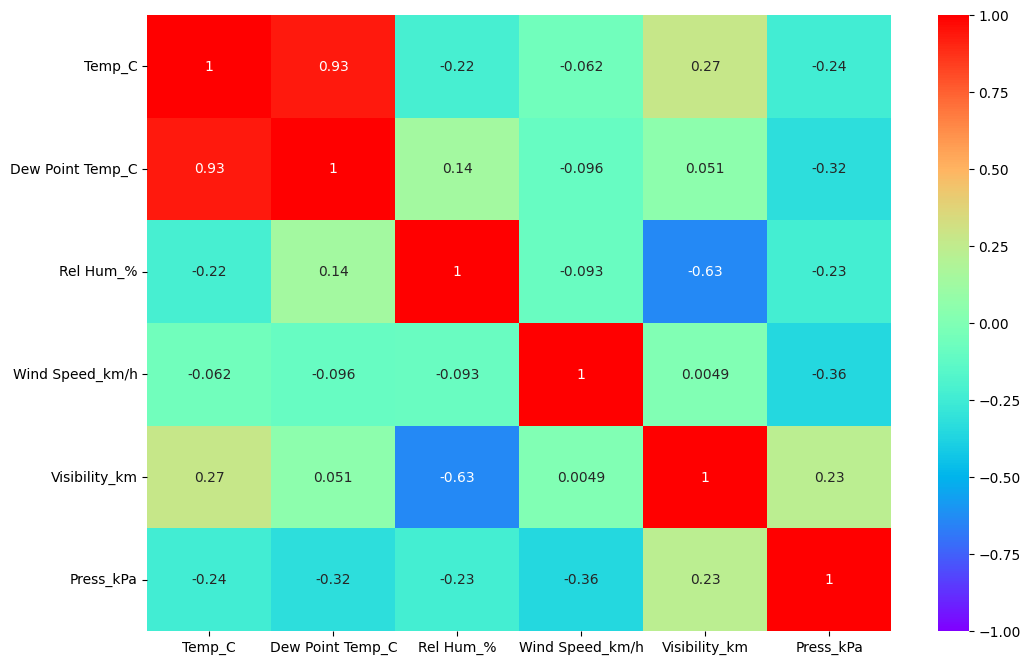

8015

In [15]:
plt.figure(figsize=(12,8))
fig = sns.heatmap(df.corr(),annot=True,cmap='rainbow',vmin=-1.0,vmax=1.0)
plt.show(fig)
plt.close('all')
del fig
gc.collect()

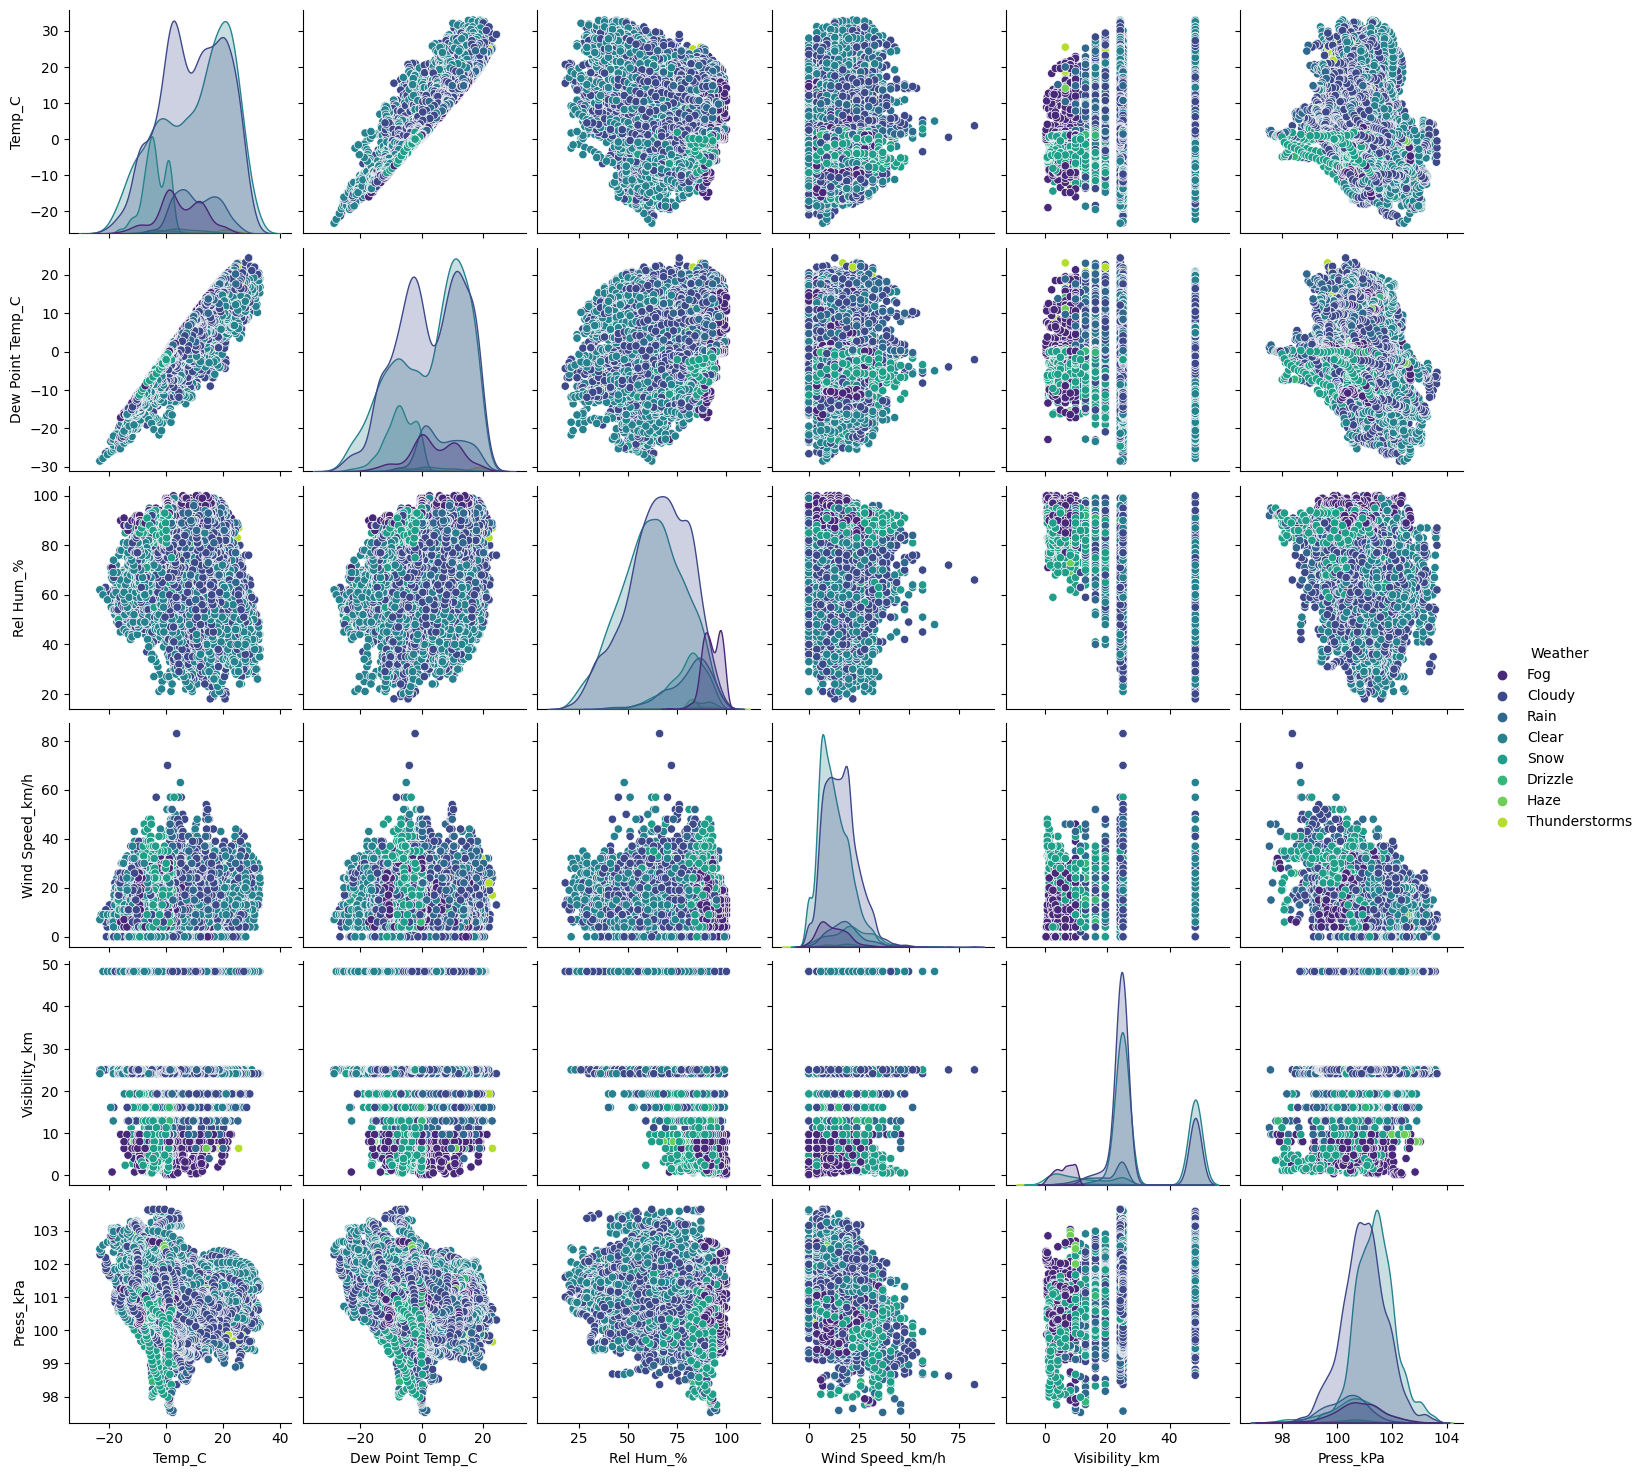

152642

In [16]:
fig = sns.pairplot(df,hue='Weather',palette='viridis')
plt.show(fig)
plt.close('all')
del fig
gc.collect()

## Feature Engineering

### Feature Extraction

In [17]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'],errors='coerce')

In [18]:
df['Year'] = df['Date/Time'].dt.year
df['Month'] = df['Date/Time'].dt.month
df['Day'] = df['Date/Time'].dt.day
df['Hour'] = df['Date/Time'].dt.hour
df['Minute'] = df['Date/Time'].dt.minute
df['Second'] = df['Date/Time'].dt.second
df['Days in Month'] = df['Date/Time'].dt.daysinmonth
df['Week'] = df['Date/Time'].dt.week
df['is_leap_year'] = df['Date/Time'].dt.is_leap_year
df['is_month_start'] = df['Date/Time'].dt.is_month_start
df['is_month_end'] = df['Date/Time'].dt.is_month_end
df['is_year_start'] = df['Date/Time'].dt.is_year_start
df['is_year_end'] = df['Date/Time'].dt.is_year_end
df['is_quarter_start'] = df['Date/Time'].dt.is_quarter_start
df['is_quarter_end'] = df['Date/Time'].dt.is_quarter_end
df['Weekday'] = df['Date/Time'].dt.weekday

In [19]:
df.drop('Date/Time',axis=1,inplace=True)

In [20]:
df['is_leap_year'] = df['is_leap_year'].astype(int)
df['is_month_end'] = df['is_month_end'].astype(int)
df['is_month_start'] = df['is_month_start'].astype(int)
df['is_quarter_end'] = df['is_quarter_end'].astype(int)
df['is_quarter_start'] = df['is_quarter_start'].astype(int)
df['is_year_end'] = df['is_year_end'].astype(int)
df['is_year_start'] = df['is_year_start'].astype(int)

### Outlier Treatment

In [21]:
skewed_cols = ['Press_kPa','Visibility_km','Wind Speed_km/h']

def remove_outliers(data,col):
    lower_limit, upper_limit = data[col].quantile([0.25,0.75])
    IQR = upper_limit - lower_limit
    lower_whisker = lower_limit - 1.5 * IQR
    upper_whisker = upper_limit + 1.5 * IQR
    return np.where(data[col]<lower_whisker,lower_whisker,np.where(data[col]>upper_whisker,upper_whisker,data[col]))

In [22]:
for col in skewed_cols:
    df[col] = remove_outliers(df,col)

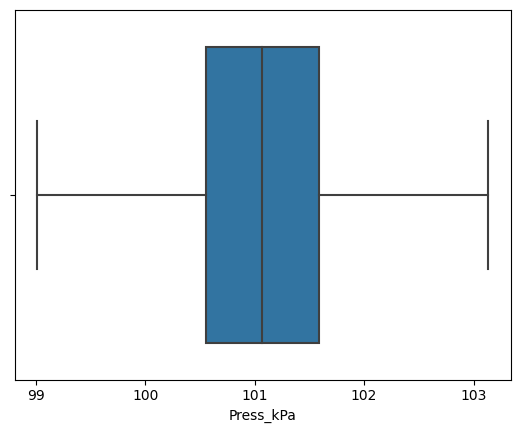

In [23]:
fig = sns.boxplot(df['Press_kPa'])
plt.show(fig)
plt.close('all')
del fig
gc.collect();

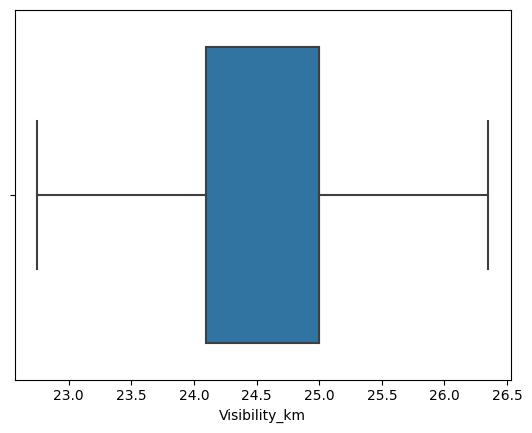

In [24]:
fig = sns.boxplot(df['Visibility_km'])
plt.show(fig)
plt.close('all')
del fig
gc.collect();

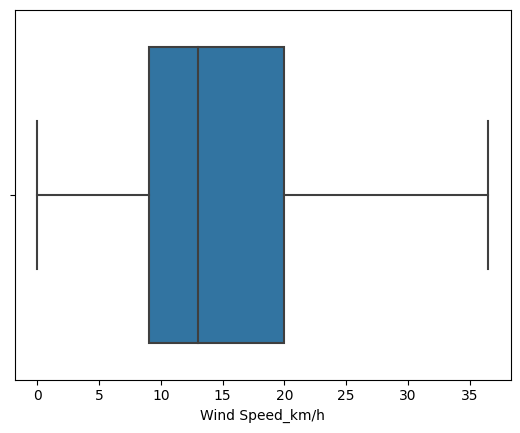

In [25]:
fig = sns.boxplot(df['Wind Speed_km/h'])
plt.show(fig)
plt.close('all')
del fig
gc.collect();

All the outliers have been imputed successfully using the winsorization technique.

### Feature Splitting

In [26]:
X = df.drop('Weather',axis=1)
y = df.Weather

### Balancing the target classes

In [27]:
borderline_smote = BorderlineSMOTE()
X, y = borderline_smote.fit_resample(X,y)

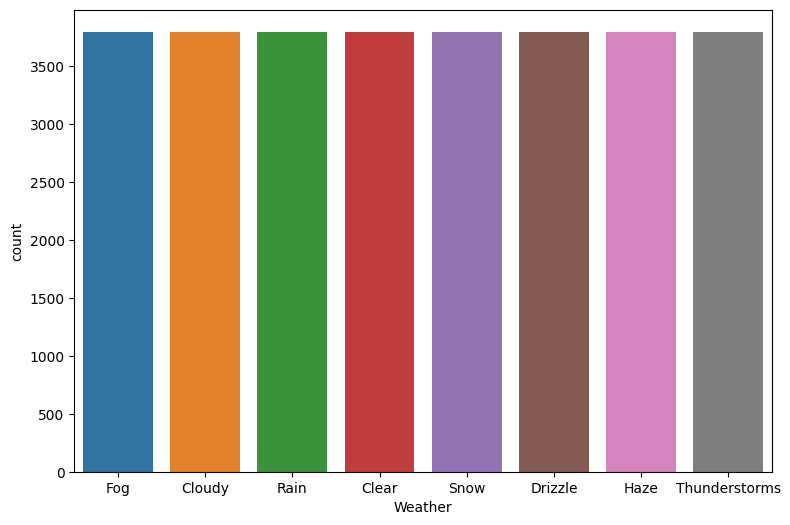

In [28]:
plt.figure(figsize=(9,6))
fig = sns.countplot(y)
plt.show(fig)
plt.close('all')
del fig
gc.collect();

In [29]:
y.value_counts()

Fog              3797
Cloudy           3797
Rain             3797
Clear            3797
Snow             3797
Drizzle          3797
Haze             3797
Thunderstorms    3797
Name: Weather, dtype: int64

In [30]:
print(Counter(y))

Counter({'Fog': 3797, 'Cloudy': 3797, 'Rain': 3797, 'Clear': 3797, 'Snow': 3797, 'Drizzle': 3797, 'Haze': 3797, 'Thunderstorms': 3797})


All the classes are perfectly balanced now so there won't be any problem of imbalanced classification.

### Train Test Split

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)

In [32]:
print("Shape of the training set:",X_train.shape)
print("Shape of the testing set:",X_test.shape)

Shape of the training set: (21263, 22)
Shape of the testing set: (9113, 22)


### Label Encoding

In [33]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [34]:
encoder.classes_

array(['Clear', 'Cloudy', 'Drizzle', 'Fog', 'Haze', 'Rain', 'Snow',
       'Thunderstorms'], dtype=object)

In [35]:
label_mapping = {label:idx for idx, label in enumerate(encoder.classes_)}
label_mapping

{'Clear': 0,
 'Cloudy': 1,
 'Drizzle': 2,
 'Fog': 3,
 'Haze': 4,
 'Rain': 5,
 'Snow': 6,
 'Thunderstorms': 7}

### Feature Selection

In [36]:
pipeline = Pipeline(steps=[
    ('constant',DropConstantFeatures()),
    ('correlated',DropCorrelatedFeatures()),
    ('duplicate',DropDuplicateFeatures())
])

In [37]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [38]:
print("Shape of the training set:",X_train.shape)
print("Shape of the testing set:",X_test.shape)

Shape of the training set: (21263, 16)
Shape of the testing set: (9113, 16)


In [39]:
kbest = SelectKBest(k=5,score_func=f_classif)
kbest.fit(X_train,y_train)

SelectKBest(k=5)

In [40]:
selected_features = kbest.get_feature_names_out()
selected_features

array(['Temp_C', 'Rel Hum_%', 'Visibility_km', 'Press_kPa',
       'is_month_start'], dtype=object)

In [41]:
percentile = SelectPercentile(percentile=30,score_func=f_classif)
percentile.fit(X_train,y_train)

SelectPercentile(percentile=30)

In [42]:
selected_features = percentile.get_feature_names_out()
selected_features

array(['Temp_C', 'Rel Hum_%', 'Visibility_km', 'Press_kPa',
       'is_month_start'], dtype=object)

In [43]:
sfm = SelectFromModel(estimator=RandomForestClassifier(),max_features=5)
sfm.fit(X_train,y_train)

SelectFromModel(estimator=RandomForestClassifier(), max_features=5)

In [44]:
selected_features = sfm.get_feature_names_out()
selected_features

array(['Temp_C', 'Rel Hum_%', 'Visibility_km', 'Press_kPa', 'Month'],
      dtype=object)

In [45]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

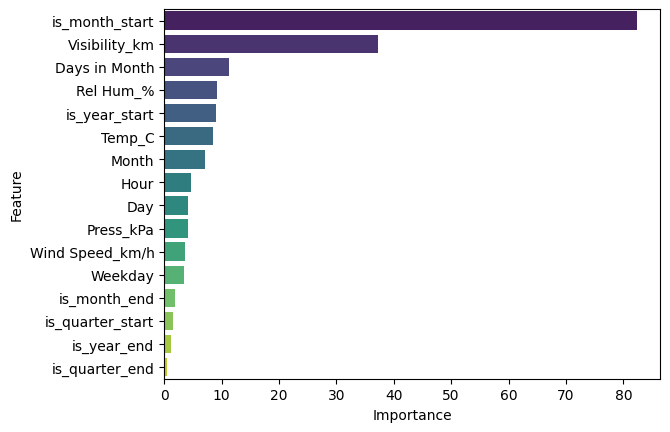

In [46]:
feat_imps = xgb.get_booster().get_score(importance_type='gain')
keys = list(feat_imps.keys())
values = list(feat_imps.values())
feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"]).sort_values(by="Importance", ascending=False).reset_index()
feat_imps_df.rename({'index': 'Feature'},axis=1,inplace=True)
fig = sns.barplot(x='Importance',y='Feature',data=feat_imps_df,orient='horizontal',palette='viridis')
plt.show(fig)
plt.close('all')
del fig
gc.collect();

In [47]:
def plot_feature_importances(feat_imp_type):
    feat_imps = xgb.get_booster().get_score(importance_type=feat_imp_type)
    keys = list(feat_imps.keys())
    values = list(feat_imps.values())
    feat_imps_df = pd.DataFrame(data=values, index=keys, columns=["Importance"]).sort_values(by="Importance", ascending=False).reset_index()
    feat_imps_df.rename({'index': 'Feature'},axis=1,inplace=True)
    fig = sns.barplot(x='Importance',y='Feature',data=feat_imps_df,orient='horizontal',palette='viridis')
    plt.title(f"{feat_imp_type.title()} Feature Importance")
    plt.show(fig)
    plt.close('all')
    del fig
    gc.collect();

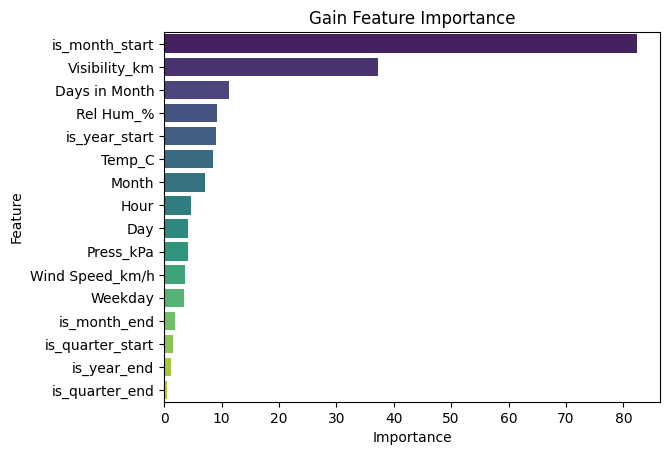

In [48]:
plot_feature_importances('gain')

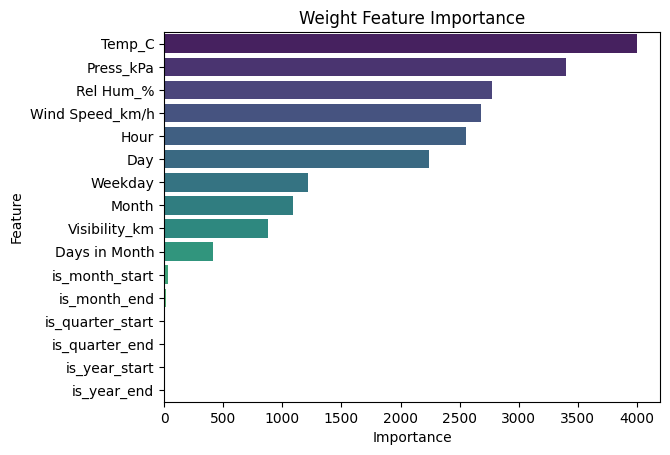

In [49]:
plot_feature_importances('weight')

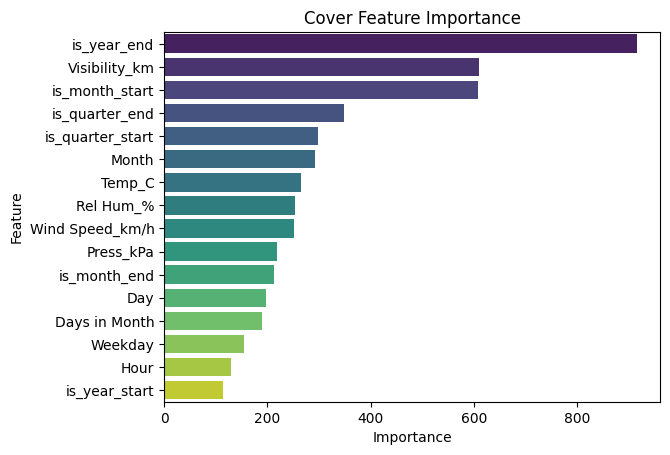

In [50]:
plot_feature_importances('cover')

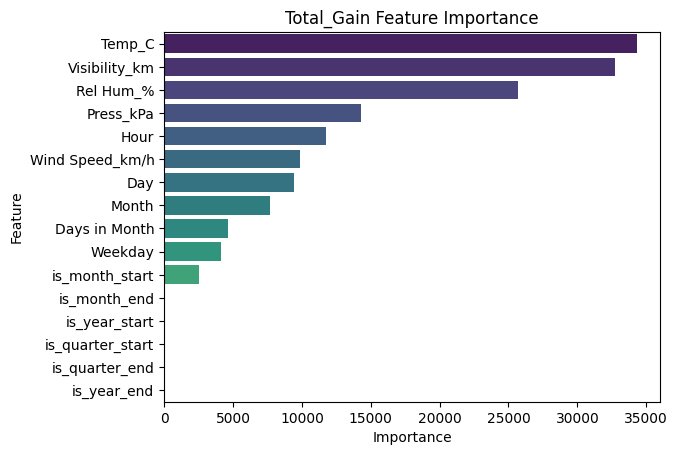

In [51]:
plot_feature_importances('total_gain')

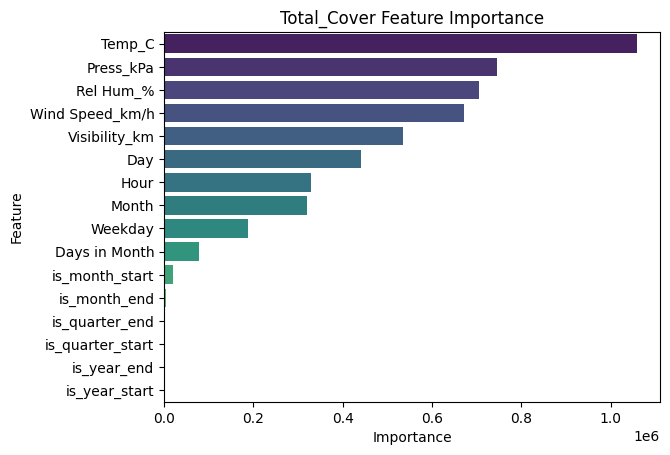

In [52]:
plot_feature_importances('total_cover')

In [55]:
final_selected_features = ['Temp_C','Press_kPa','Rel Hum_%','Wind Speed_km/h','Visibility_km','Hour']

final_X_train = X_train[final_selected_features]
final_X_test = X_test[final_selected_features]

In [57]:
gc.collect()

0

### Feature Scaling

In [58]:
scaler = StandardScaler()
features = final_X_train.columns
final_X_train = scaler.fit_transform(final_X_train)
final_X_train = pd.DataFrame(final_X_train,columns=features)
final_X_test = scaler.transform(final_X_test)
final_X_test = pd.DataFrame(final_X_test,columns=features)
final_X_train.head()

Temp_C  Press_kPa  Rel Hum_%  Wind Speed_km/h  Visibility_km      Hour
0 -0.575040  -2.180506   1.137507         1.624662      -0.773587  1.567871
1 -1.141952   1.754661  -1.227264         0.856693       0.420652 -0.354392
2 -0.655171  -0.340502  -0.080709         0.589265       0.313932 -1.155334
3 -0.498976  -2.180506   0.779208         2.528918      -0.773587  0.606739
4 -0.263238  -0.129019   0.134271        -0.534049      -0.773587 -0.834957

## Model Training & Evaluation

In [80]:
models = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

In [81]:
def train_and_evaluate_model(model):
    model.fit(final_X_train,y_train)
    y_pred = model.predict(final_X_test)
    print("Classification Report:")
    print(classification_report(y_test,y_pred))
    print('-'*50)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred,average='macro')
    recall = recall_score(y_test,y_pred,average='macro')
    f1 = f1_score(y_test,y_pred,average='macro')
    accuracy_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    models.append(model)
    gc.collect()

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1150
           1       0.42      0.32      0.36      1130
           2       0.59      0.52      0.55      1159
           3       0.58      0.69      0.63      1145
           4       0.75      0.93      0.83      1125
           5       0.43      0.34      0.38      1133
           6       0.56      0.53      0.54      1136
           7       0.76      0.87      0.81      1135

    accuracy                           0.61      9113
   macro avg       0.59      0.61      0.60      9113
weighted avg       0.59      0.61      0.60      9113

--------------------------------------------------


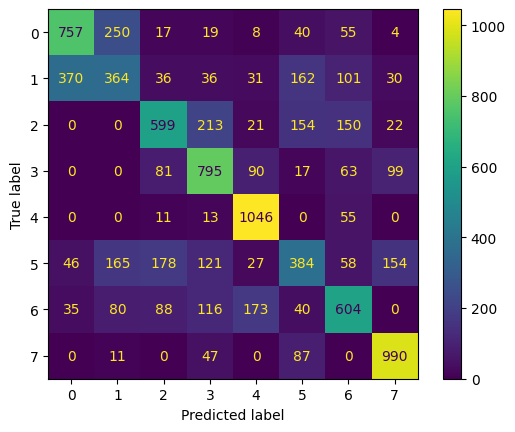

In [83]:
train_and_evaluate_model(LogisticRegression())

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.78      0.65      1150
           1       0.43      0.21      0.28      1130
           2       0.50      0.52      0.51      1159
           3       0.53      0.71      0.61      1145
           4       0.67      0.96      0.79      1125
           5       0.50      0.03      0.06      1133
           6       0.50      0.52      0.51      1136
           7       0.74      0.90      0.81      1135

    accuracy                           0.58      9113
   macro avg       0.55      0.58      0.53      9113
weighted avg       0.55      0.58      0.53      9113

--------------------------------------------------


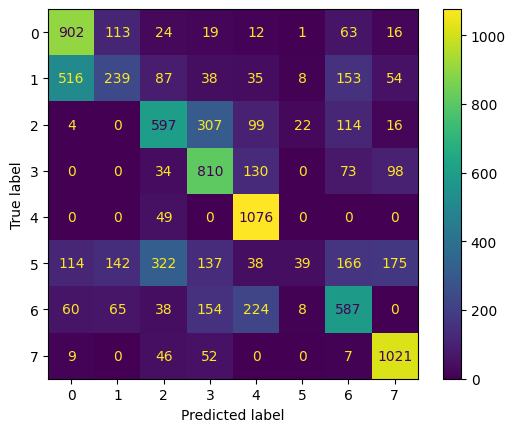

In [84]:
train_and_evaluate_model(SGDClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.44      0.50      1150
           1       0.22      0.06      0.10      1130
           2       0.31      0.80      0.44      1159
           3       0.54      0.31      0.40      1145
           4       0.46      0.33      0.38      1125
           5       0.27      0.17      0.21      1133
           6       0.31      0.50      0.38      1136
           7       0.73      0.55      0.63      1135

    accuracy                           0.40      9113
   macro avg       0.43      0.40      0.38      9113
weighted avg       0.43      0.40      0.38      9113

--------------------------------------------------


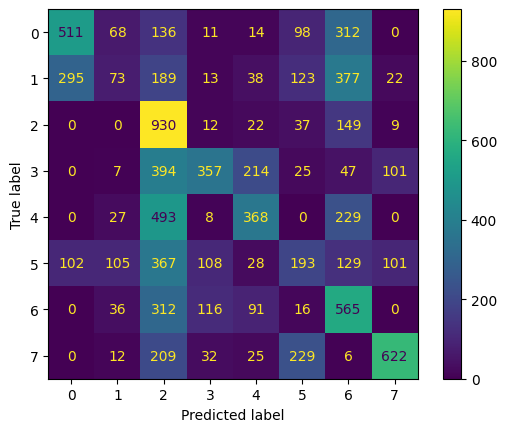

In [85]:
train_and_evaluate_model(PassiveAggressiveClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.82      0.64      1150
           1       0.46      0.06      0.10      1130
           2       0.65      0.52      0.58      1159
           3       0.63      0.37      0.47      1145
           4       0.58      0.93      0.71      1125
           5       0.54      0.14      0.23      1133
           6       0.50      0.57      0.53      1136
           7       0.50      0.95      0.66      1135

    accuracy                           0.55      9113
   macro avg       0.55      0.55      0.49      9113
weighted avg       0.55      0.55      0.49      9113

--------------------------------------------------


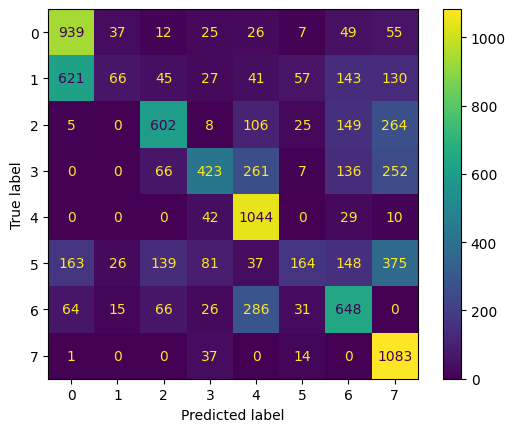

In [86]:
train_and_evaluate_model(RidgeClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      1150
           1       0.63      0.49      0.55      1130
           2       0.95      0.99      0.97      1159
           3       0.92      0.96      0.94      1145
           4       0.98      1.00      0.99      1125
           5       0.84      0.88      0.86      1133
           6       0.91      0.96      0.94      1136
           7       0.98      1.00      0.99      1135

    accuracy                           0.87      9113
   macro avg       0.86      0.87      0.87      9113
weighted avg       0.86      0.87      0.87      9113

--------------------------------------------------


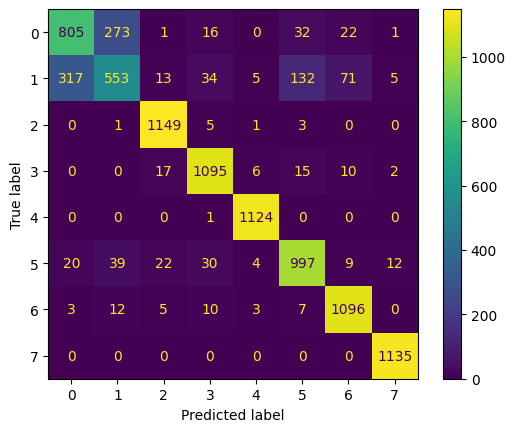

In [87]:
train_and_evaluate_model(KNeighborsClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      1150
           1       0.56      0.35      0.43      1130
           2       0.83      0.94      0.88      1159
           3       0.78      0.83      0.80      1145
           4       0.94      1.00      0.97      1125
           5       0.72      0.58      0.64      1133
           6       0.80      0.85      0.83      1136
           7       0.92      0.99      0.95      1135

    accuracy                           0.79      9113
   macro avg       0.77      0.79      0.78      9113
weighted avg       0.77      0.79      0.78      9113

--------------------------------------------------


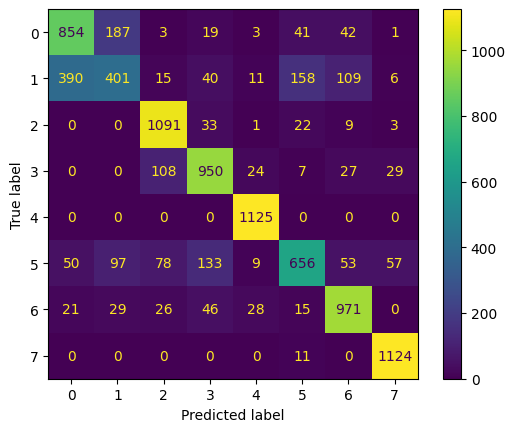

In [90]:
train_and_evaluate_model(SVC())

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1150
           1       0.54      0.38      0.45      1130
           2       0.72      0.78      0.75      1159
           3       0.64      0.61      0.63      1145
           4       0.71      0.99      0.83      1125
           5       0.60      0.38      0.47      1133
           6       0.63      0.63      0.63      1136
           7       0.78      0.88      0.83      1135

    accuracy                           0.67      9113
   macro avg       0.66      0.67      0.66      9113
weighted avg       0.66      0.67      0.66      9113

--------------------------------------------------


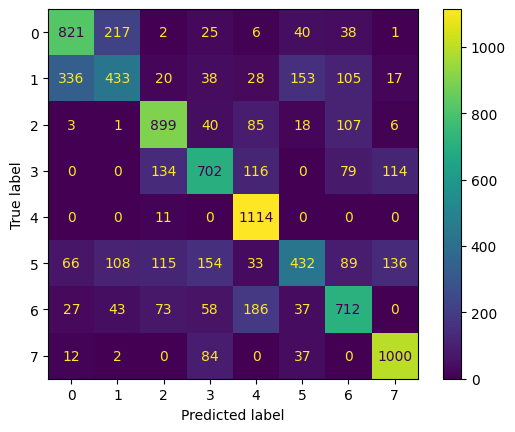

In [91]:
train_and_evaluate_model(NuSVC())

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.80      0.66      1150
           1       0.42      0.15      0.22      1130
           2       0.63      0.54      0.58      1159
           3       0.57      0.69      0.62      1145
           4       0.68      0.95      0.80      1125
           5       0.53      0.23      0.32      1133
           6       0.51      0.52      0.52      1136
           7       0.70      0.91      0.80      1135

    accuracy                           0.60      9113
   macro avg       0.58      0.60      0.56      9113
weighted avg       0.58      0.60      0.56      9113

--------------------------------------------------


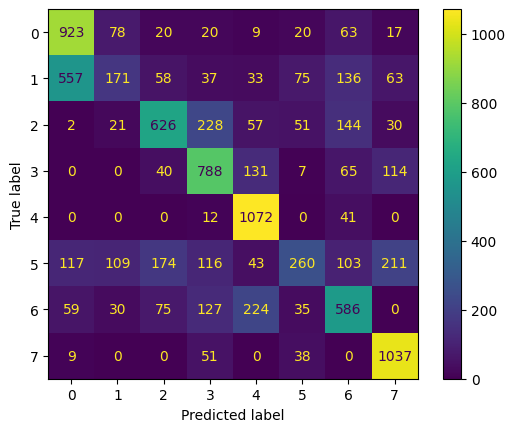

In [92]:
train_and_evaluate_model(LinearSVC())

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1150
           1       0.44      0.28      0.34      1130
           2       0.82      0.53      0.65      1159
           3       0.36      0.93      0.52      1145
           4       0.67      0.99      0.80      1125
           5       0.54      0.38      0.45      1133
           6       0.73      0.36      0.48      1136
           7       0.83      0.22      0.35      1135

    accuracy                           0.55      9113
   macro avg       0.63      0.55      0.53      9113
weighted avg       0.63      0.55      0.53      9113

--------------------------------------------------


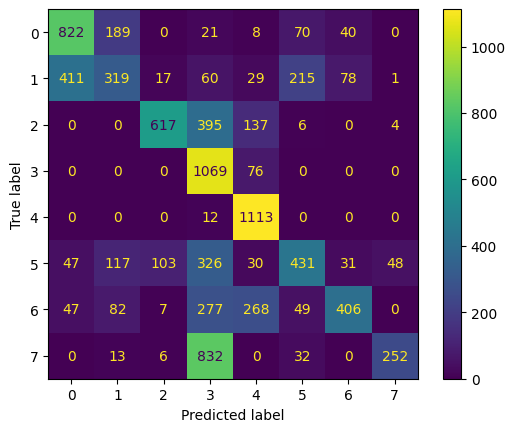

In [93]:
train_and_evaluate_model(GaussianNB())

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1150
           1       0.35      0.38      0.36      1130
           2       0.52      0.49      0.50      1159
           3       0.37      0.36      0.36      1145
           4       0.50      0.82      0.63      1125
           5       0.42      0.13      0.20      1133
           6       0.62      0.37      0.46      1136
           7       0.64      0.85      0.73      1135

    accuracy                           0.50      9113
   macro avg       0.50      0.50      0.48      9113
weighted avg       0.50      0.50      0.48      9113

--------------------------------------------------


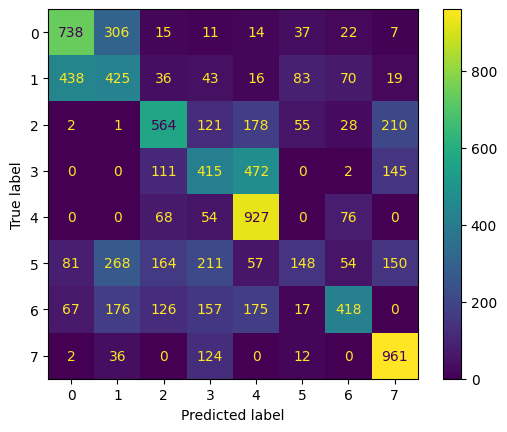

In [94]:
train_and_evaluate_model(BernoulliNB())

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      1150
           1       0.60      0.59      0.60      1130
           2       0.98      0.98      0.98      1159
           3       0.94      0.95      0.94      1145
           4       1.00      0.99      1.00      1125
           5       0.86      0.86      0.86      1133
           6       0.93      0.95      0.94      1136
           7       0.99      0.99      0.99      1135

    accuracy                           0.87      9113
   macro avg       0.87      0.87      0.87      9113
weighted avg       0.87      0.87      0.87      9113

--------------------------------------------------


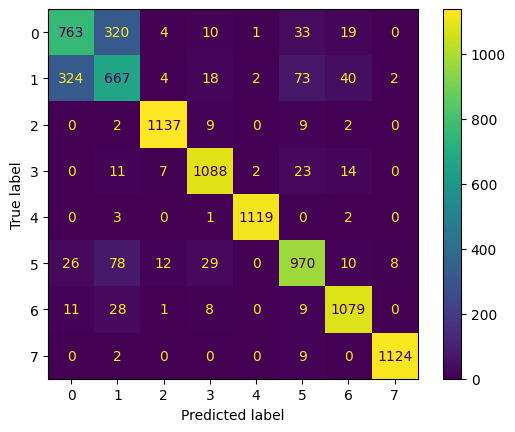

In [97]:
train_and_evaluate_model(DecisionTreeClassifier())

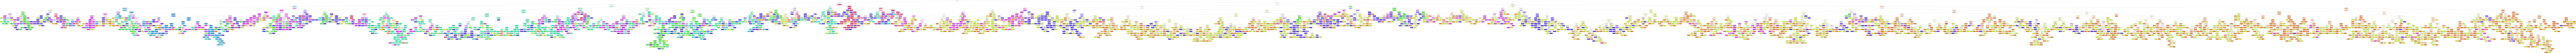

In [105]:
export_graphviz(decision_tree=models[-1],
                out_file='tree.dot',
                feature_names=final_X_train.columns,
                class_names=encoder.classes_,
                rounded=True,
                proportion=False,
                precision=2,
                filled=True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
# Display in jupyter notebook
Image(filename = 'tree.png')

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.76      1150
           1       0.71      0.64      0.67      1130
           2       0.99      0.99      0.99      1159
           3       0.94      0.98      0.96      1145
           4       1.00      1.00      1.00      1125
           5       0.92      0.92      0.92      1133
           6       0.95      0.98      0.96      1136
           7       1.00      0.99      1.00      1135

    accuracy                           0.91      9113
   macro avg       0.91      0.91      0.91      9113
weighted avg       0.91      0.91      0.91      9113

--------------------------------------------------


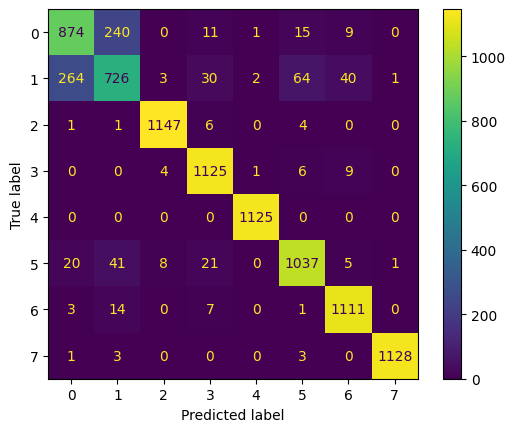

In [106]:
train_and_evaluate_model(RandomForestClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1150
           1       0.59      0.51      0.55      1130
           2       0.91      0.93      0.92      1159
           3       0.82      0.91      0.87      1145
           4       0.97      1.00      0.99      1125
           5       0.77      0.65      0.70      1133
           6       0.85      0.90      0.87      1136
           7       0.95      0.98      0.97      1135

    accuracy                           0.82      9113
   macro avg       0.82      0.82      0.82      9113
weighted avg       0.82      0.82      0.82      9113

--------------------------------------------------


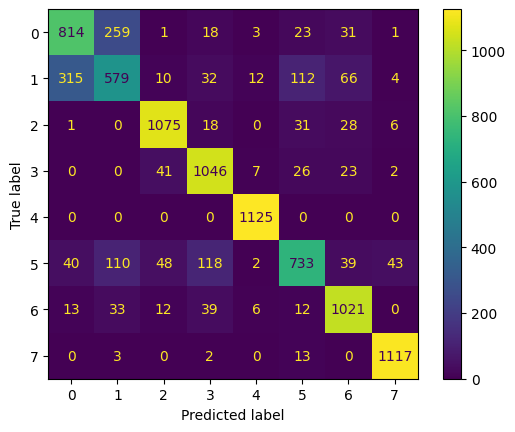

In [107]:
train_and_evaluate_model(GradientBoostingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.88      0.60      1150
           1       0.00      0.00      0.00      1130
           2       0.36      0.33      0.34      1159
           3       0.36      0.18      0.24      1145
           4       0.31      0.99      0.47      1125
           5       0.34      0.08      0.13      1133
           6       0.96      0.04      0.08      1136
           7       0.76      0.87      0.81      1135

    accuracy                           0.42      9113
   macro avg       0.44      0.42      0.33      9113
weighted avg       0.44      0.42      0.33      9113

--------------------------------------------------


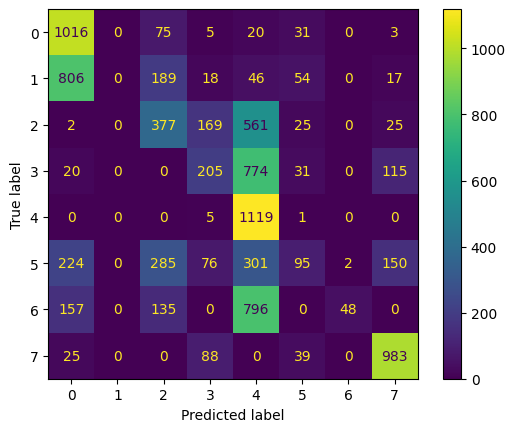

In [108]:
train_and_evaluate_model(AdaBoostClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      1150
           1       0.69      0.62      0.66      1130
           2       0.98      0.99      0.99      1159
           3       0.94      0.97      0.95      1145
           4       0.99      1.00      1.00      1125
           5       0.91      0.87      0.89      1133
           6       0.94      0.96      0.95      1136
           7       0.99      0.99      0.99      1135

    accuracy                           0.90      9113
   macro avg       0.89      0.90      0.89      9113
weighted avg       0.89      0.90      0.89      9113

--------------------------------------------------


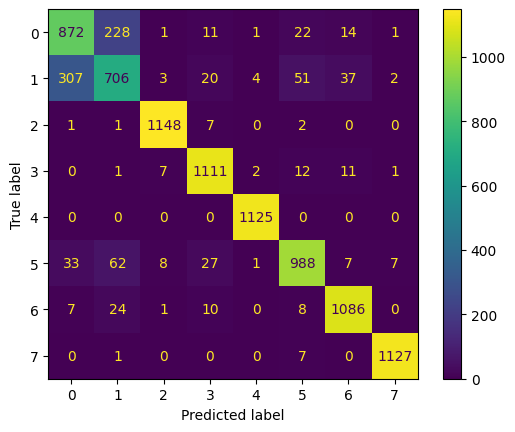

In [109]:
train_and_evaluate_model(BaggingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1150
           1       0.69      0.62      0.65      1130
           2       0.98      0.99      0.99      1159
           3       0.94      0.97      0.95      1145
           4       1.00      1.00      1.00      1125
           5       0.91      0.90      0.91      1133
           6       0.95      0.97      0.96      1136
           7       0.99      1.00      1.00      1135

    accuracy                           0.90      9113
   macro avg       0.90      0.90      0.90      9113
weighted avg       0.90      0.90      0.90      9113

--------------------------------------------------


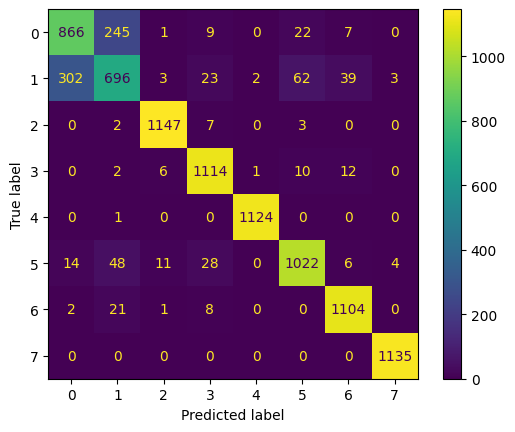

In [110]:
train_and_evaluate_model(HistGradientBoostingClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1150
           1       0.73      0.65      0.69      1130
           2       0.99      0.99      0.99      1159
           3       0.94      0.99      0.97      1145
           4       1.00      1.00      1.00      1125
           5       0.93      0.93      0.93      1133
           6       0.95      0.98      0.96      1136
           7       1.00      1.00      1.00      1135

    accuracy                           0.92      9113
   macro avg       0.91      0.91      0.91      9113
weighted avg       0.91      0.92      0.91      9113

--------------------------------------------------


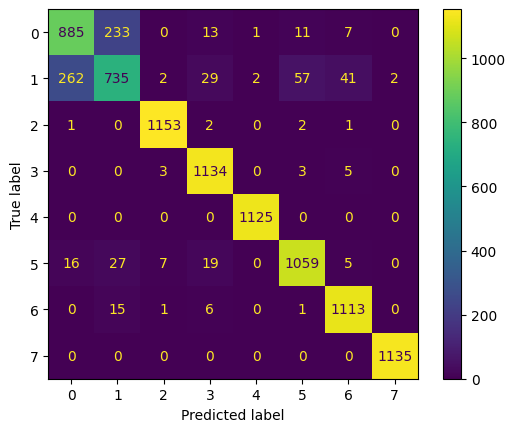

In [111]:
train_and_evaluate_model(ExtraTreesClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1150
           1       0.69      0.64      0.66      1130
           2       0.98      0.99      0.98      1159
           3       0.93      0.97      0.95      1145
           4       0.99      1.00      1.00      1125
           5       0.93      0.88      0.90      1133
           6       0.94      0.97      0.95      1136
           7       1.00      1.00      1.00      1135

    accuracy                           0.90      9113
   macro avg       0.90      0.90      0.90      9113
weighted avg       0.90      0.90      0.90      9113

--------------------------------------------------


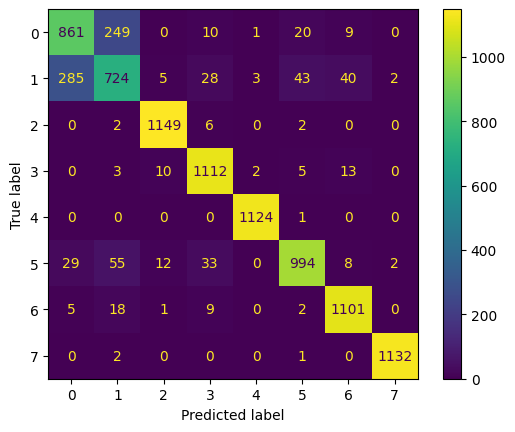

In [112]:
train_and_evaluate_model(XGBClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.78      0.70      1150
           1       0.56      0.41      0.47      1130
           2       0.87      0.90      0.88      1159
           3       0.75      0.86      0.80      1145
           4       0.89      1.00      0.94      1125
           5       0.84      0.48      0.61      1133
           6       0.78      0.83      0.80      1136
           7       0.90      0.99      0.95      1135

    accuracy                           0.78      9113
   macro avg       0.78      0.78      0.77      9113
weighted avg       0.78      0.78      0.77      9113

--------------------------------------------------


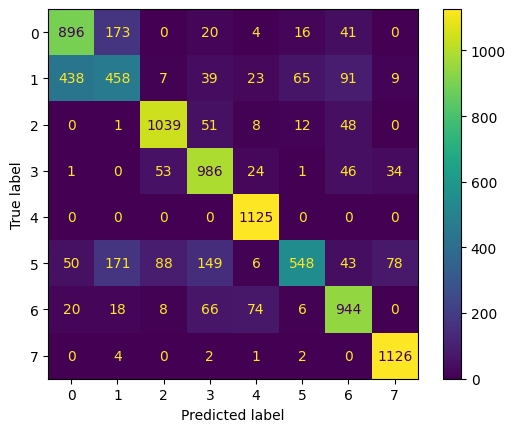

In [113]:
train_and_evaluate_model(XGBRFClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1150
           1       0.69      0.62      0.65      1130
           2       0.98      0.99      0.99      1159
           3       0.93      0.97      0.95      1145
           4       1.00      1.00      1.00      1125
           5       0.93      0.89      0.91      1133
           6       0.93      0.97      0.95      1136
           7       1.00      1.00      1.00      1135

    accuracy                           0.90      9113
   macro avg       0.90      0.90      0.90      9113
weighted avg       0.90      0.90      0.90      9113

--------------------------------------------------


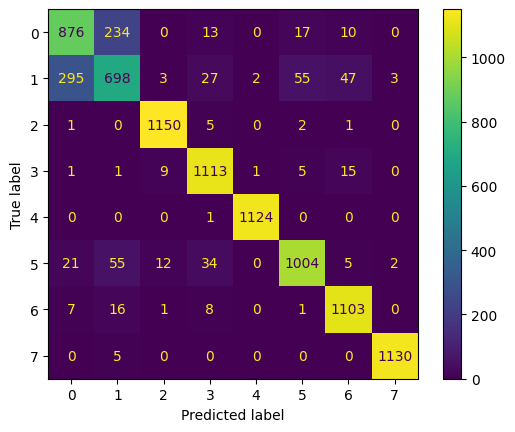

In [114]:
train_and_evaluate_model(LGBMClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1150
           1       0.69      0.61      0.65      1130
           2       0.96      0.99      0.97      1159
           3       0.91      0.96      0.93      1145
           4       0.99      1.00      0.99      1125
           5       0.90      0.85      0.87      1133
           6       0.92      0.96      0.94      1136
           7       0.99      1.00      0.99      1135

    accuracy                           0.89      9113
   macro avg       0.89      0.89      0.89      9113
weighted avg       0.89      0.89      0.89      9113

--------------------------------------------------


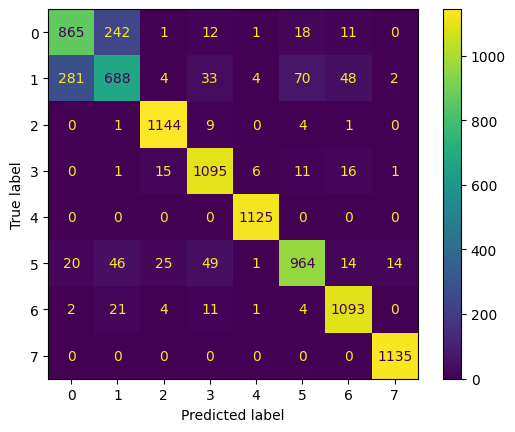

In [115]:
train_and_evaluate_model(CatBoostClassifier(silent=True))

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1150
           1       0.56      0.38      0.45      1130
           2       0.92      0.96      0.94      1159
           3       0.82      0.93      0.87      1145
           4       0.99      1.00      0.99      1125
           5       0.77      0.66      0.71      1133
           6       0.81      0.94      0.87      1136
           7       0.97      1.00      0.98      1135

    accuracy                           0.82      9113
   macro avg       0.81      0.82      0.81      9113
weighted avg       0.81      0.82      0.81      9113

--------------------------------------------------


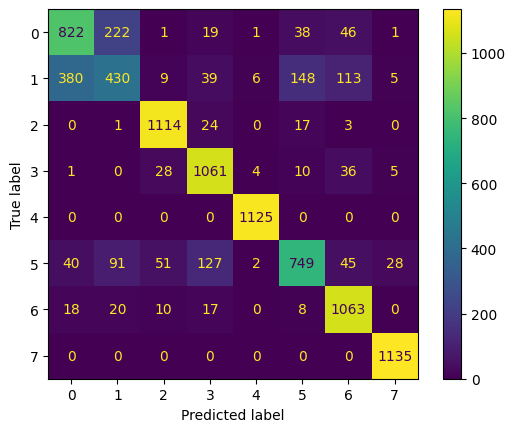

In [116]:
train_and_evaluate_model(MLPClassifier())

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.82      0.77      1150
           1       0.74      0.62      0.67      1130
           2       0.98      0.99      0.99      1159
           3       0.93      0.98      0.96      1145
           4       1.00      1.00      1.00      1125
           5       0.94      0.89      0.92      1133
           6       0.95      0.97      0.96      1136
           7       1.00      1.00      1.00      1135

    accuracy                           0.91      9113
   macro avg       0.91      0.91      0.91      9113
weighted avg       0.91      0.91      0.91      9113

--------------------------------------------------


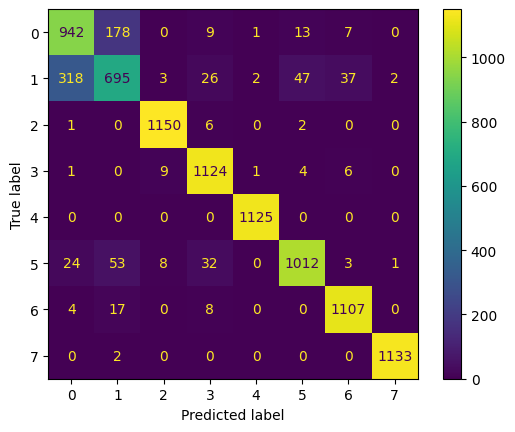

In [117]:
train_and_evaluate_model(VotingClassifier(estimators=[
    ('LGBM',LGBMClassifier()),
    ('XGB',XGBClassifier()),
    ('ET',ExtraTreesClassifier()),
    ('HGB',HistGradientBoostingClassifier()),
    ('BAG',BaggingClassifier()),
    ('RF',RandomForestClassifier())
],voting='hard',n_jobs=-1,verbose=2))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      1150
           1       0.72      0.63      0.67      1130
           2       0.99      0.99      0.99      1159
           3       0.96      0.99      0.97      1145
           4       1.00      1.00      1.00      1125
           5       0.93      0.92      0.93      1133
           6       0.96      0.97      0.97      1136
           7       1.00      1.00      1.00      1135

    accuracy                           0.91      9113
   macro avg       0.91      0.91      0.91      9113
weighted avg       0.91      0.91      0.91      9113

--------------------------------------------------


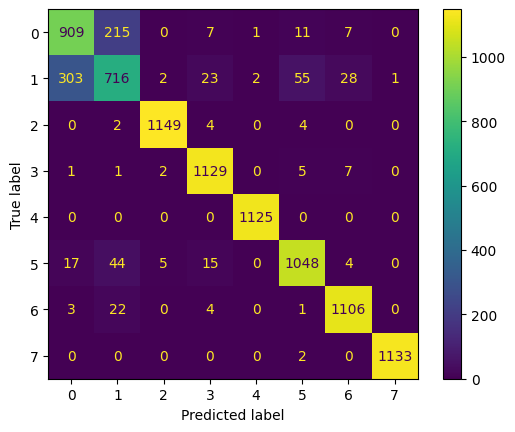

In [120]:
train_and_evaluate_model(StackingClassifier(estimators=[
    ('LGBM',LGBMClassifier()),
    ('XGB',XGBClassifier()),
    ('ET',ExtraTreesClassifier()),
    ('HGB',HistGradientBoostingClassifier()),
    ('BAG',BaggingClassifier()),
    ('RF',RandomForestClassifier())
],final_estimator=DecisionTreeClassifier(),n_jobs=-1,verbose=3,stack_method='predict'))

## Baseline Models Performance Comparison

In [121]:
model_perfs = pd.DataFrame({'Model': models, 
                            'Accuracy': accuracy_scores, 
                            'Precision': precision_scores,
                            'Recall': recall_scores,
                            'F1': f1_scores}).sort_values('Accuracy',ascending=False).reset_index()
model_perfs

index                                              Model  Accuracy  \
0      16  (ExtraTreeClassifier(random_state=1482192489),...  0.915066   
1      23  StackingClassifier(estimators=[('LGBM', LGBMCl...  0.912433   
2      22  VotingClassifier(estimators=[('LGBM', LGBMClas...  0.909470   
3      11  (DecisionTreeClassifier(max_features='auto', r...  0.907824   
4      15                   HistGradientBoostingClassifier()  0.900691   
5      19                                   LGBMClassifier()  0.899594   
6      17  XGBClassifier(base_score=None, booster=None, c...  0.899484   
7      14  (DecisionTreeClassifier(random_state=188438187...  0.895753   
8      20  <catboost.core.CatBoostClassifier object at 0x...  0.889828   
9       4                             KNeighborsClassifier()  0.872819   
10     10                           DecisionTreeClassifier()  0.872051   
11     12  ([DecisionTreeRegressor(criterion='friedman_ms...  0.824097   
12     21                                    MLPClassifier()  0.822890   
13      5                                              SVC()  0.787008   
14     18  XGBRFClassifier(base_score=None, booster=None,...  0.781521   
15      6                                            NuSVC()  0.670800   
16      0                               LogisticRegression()  0.607813   
17      7                                        LinearSVC()  0.599473   
18      1                                    SGDClassifier()  0.578404   
19      8                                       GaussianNB()  0.551849   
20      3                                  RidgeClassifier()  0.545265   
21      9                                      BernoulliNB()  0.504334   
22     13  (DecisionTreeClassifier(max_depth=1, random_st...  0.421705   
23      2                      PassiveAggressiveClassifier()  0.397125   

    Precision    Recall        F1  
0    0.912432  0.914958  0.913316  
1    0.910984  0.912284  0.911166  
2    0.908534  0.909248  0.907736  
3    0.905389  0.907719  0.906251  
4    0.898121  0.900565  0.899016  
5    0.897463  0.899441  0.897972  
6    0.897968  0.899366  0.898354  
7    0.894309  0.895602  0.894582  
8    0.886468  0.889675  0.887501  
9    0.864778  0.872619  0.867317  
10   0.870530  0.871989  0.871214  
11   0.818361  0.823892  0.819619  
12   0.812366  0.822493  0.813505  
13   0.774465  0.786569  0.775279  
14   0.778361  0.781096  0.770029  
15   0.658758  0.670650  0.656367  
16   0.590580  0.608021  0.595106  
17   0.576408  0.599267  0.563961  
18   0.554186  0.578191  0.528232  
19   0.625878  0.551528  0.530777  
20   0.547003  0.545141  0.489164  
21   0.498064  0.504525  0.480590  
22   0.442862  0.421831  0.334297  
23   0.425285  0.395748  0.379462

The Extra Trees Classifier is the best performing model that achieves an outstanding accuracy of more than 91.5% on the test set. It is closely followed by the Stacking and Voting classifiers.

## Hyperparameter Tuning and Cross Validation

In [127]:
param_grid = {'penalty': ['l1','l2','elasticnet'],
              'C': [0.001,0.01,0.1,0.5],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'multi_class': ['ovr', 'multinomial'],
              'l1_ratio': [0.2,0.5,0.8]
             }

grid_lr = RandomizedSearchCV(LogisticRegression(),param_grid,verbose=3,cv=5)
grid_lr.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=0.5, l1_ratio=0.8, multi_class=ovr, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.5, l1_ratio=0.8, multi_class=ovr, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.5, l1_ratio=0.8, multi_class=ovr, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.5, l1_ratio=0.8, multi_class=ovr, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.5, l1_ratio=0.8, multi_class=ovr, penalty=elasticnet, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.5, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.5, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.5, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=liblinear;, score=nan total time= 

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 0.5],
                                        'l1_ratio': [0.2, 0.5, 0.8],
                                        'multi_class': ['ovr', 'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   verbose=3)

In [128]:
grid_lr.best_score_

0.5976106622982527

In [129]:
grid_lr.best_params_

{'solver': 'liblinear',
 'penalty': 'l2',
 'multi_class': 'ovr',
 'l1_ratio': 0.2,
 'C': 0.1}

In [131]:
param_grid = {'penalty': ['l1','l2'],
             'loss': ['hinge','squared_hinge'],
             'C': [0.0001,0.001,0.01,0.1,1],
             'multi_class': ['ovr','crammer_singer']}

grid_lsvc = RandomizedSearchCV(LinearSVC(),param_grid,cv=KFold(shuffle=True),verbose=2)
grid_lsvc.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END .....C=0.1, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.0s
[CV] END .....C=0.1, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.0s
[CV] END .....C=0.1, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.0s
[CV] END .....C=0.1, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.0s
[CV] END .....C=0.1, loss=hinge, multi_class=ovr, penalty=l2; total time=   0.0s
[CV] END C=0.001, loss=squared_hinge, multi_class=crammer_singer, penalty=l2; total time=   0.0s
[CV] END C=0.001, loss=squared_hinge, multi_class=crammer_singer, penalty=l2; total time=   0.0s
[CV] END C=0.001, loss=squared_hinge, multi_class=crammer_singer, penalty=l2; total time=   0.0s
[CV] END C=0.001, loss=squared_hinge, multi_class=crammer_singer, penalty=l2; total time=   0.0s
[CV] END C=0.001, loss=squared_hinge, multi_class=crammer_singer, penalty=l2; total time=   0.0s
[CV] END C=0.01, loss=squared_hinge, multi_class=

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=LinearSVC(),
                   param_distributions={'C': [0.0001, 0.001, 0.01, 0.1, 1],
                                        'loss': ['hinge', 'squared_hinge'],
                                        'multi_class': ['ovr',
                                                        'crammer_singer'],
                                        'penalty': ['l1', 'l2']},
                   verbose=2)

In [132]:
grid_lsvc.best_score_

0.5969523145523529

In [133]:
grid_lsvc.best_params_

{'penalty': 'l2',
 'multi_class': 'crammer_singer',
 'loss': 'squared_hinge',
 'C': 1}

In [194]:
param_grid = {'criterion': ['gini','entropy','log_loss'],
              'splitter': ['best','random'],
              'max_features': ['sqrt','log2']
             }

grid_dt = GridSearchCV(DecisionTreeClassifier(),param_grid,verbose=4,cv=5)
grid_dt.fit(final_X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END criterion=gini, max_features=sqrt, splitter=best;, score=0.846 total time=   0.0s
[CV 2/5] END criterion=gini, max_features=sqrt, splitter=best;, score=0.847 total time=   0.0s
[CV 3/5] END criterion=gini, max_features=sqrt, splitter=best;, score=0.856 total time=   0.0s
[CV 4/5] END criterion=gini, max_features=sqrt, splitter=best;, score=0.850 total time=   0.0s
[CV 5/5] END criterion=gini, max_features=sqrt, splitter=best;, score=0.851 total time=   0.0s
[CV 1/5] END criterion=gini, max_features=sqrt, splitter=random;, score=0.830 total time=   0.0s
[CV 2/5] END criterion=gini, max_features=sqrt, splitter=random;, score=0.826 total time=   0.0s
[CV 3/5] END criterion=gini, max_features=sqrt, splitter=random;, score=0.830 total time=   0.0s
[CV 4/5] END criterion=gini, max_features=sqrt, splitter=random;, score=0.832 total time=   0.0s
[CV 5/5] END criterion=gini, max_features=sqrt, splitter=random;, score=0.83

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             verbose=4)

In [195]:
grid_dt.best_score_

0.8525139025321952

In [196]:
grid_dt.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'splitter': 'best'}

In [199]:
param_grid = {'C': [0.001,0.01,0.1,1,5],
             'gamma': ['scale','auto'],
             'kernel': ['linear','poly','rbf','sigmoid'],
             'degree': [2,3,4,5],
             'shrinking': [True,False]
             }

grid_svm = RandomizedSearchCV(SVC(),param_grid,verbose=3,cv=KFold(shuffle=True))
grid_svm.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=1, degree=2, gamma=scale, kernel=linear, shrinking=True;, score=0.620 total time=   7.8s
[CV 2/5] END C=1, degree=2, gamma=scale, kernel=linear, shrinking=True;, score=0.642 total time=   6.1s
[CV 3/5] END C=1, degree=2, gamma=scale, kernel=linear, shrinking=True;, score=0.614 total time=   5.8s
[CV 4/5] END C=1, degree=2, gamma=scale, kernel=linear, shrinking=True;, score=0.629 total time=   6.1s
[CV 5/5] END C=1, degree=2, gamma=scale, kernel=linear, shrinking=True;, score=0.630 total time=   7.5s
[CV 1/5] END C=0.001, degree=2, gamma=scale, kernel=poly, shrinking=True;, score=0.226 total time=   7.7s
[CV 2/5] END C=0.001, degree=2, gamma=scale, kernel=poly, shrinking=True;, score=0.269 total time=   7.4s
[CV 3/5] END C=0.001, degree=2, gamma=scale, kernel=poly, shrinking=True;, score=0.203 total time=   7.4s
[CV 4/5] END C=0.001, degree=2, gamma=scale, kernel=poly, shrinking=True;, score=0.248 total time=   

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=SVC(),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 5],
                                        'degree': [2, 3, 4, 5],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid'],
                                        'shrinking': [True, False]},
                   verbose=3)

In [203]:
grid_svm.best_score_

0.8127733862367974

In [204]:
grid_svm.best_params_

{'shrinking': True, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 5, 'C': 5}

In [200]:
param_grid = {'learning_rate': [0.2,0.4,0.5,0.8,1.0],
              'loss': ['binary_crossentropy', 'categorical_crossentropy']}

grid_hgb = RandomizedSearchCV(HistGradientBoostingClassifier(),param_grid,cv=5,verbose=2)
grid_hgb.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ........learning_rate=0.2, loss=binary_crossentropy; total time=   0.0s
[CV] END ........learning_rate=0.2, loss=binary_crossentropy; total time=   0.0s
[CV] END ........learning_rate=0.2, loss=binary_crossentropy; total time=   0.0s
[CV] END ........learning_rate=0.2, loss=binary_crossentropy; total time=   0.0s
[CV] END ........learning_rate=0.2, loss=binary_crossentropy; total time=   0.0s
[CV] END ...learning_rate=0.2, loss=categorical_crossentropy; total time=   4.2s
[CV] END ...learning_rate=0.2, loss=categorical_crossentropy; total time=   4.0s
[CV] END ...learning_rate=0.2, loss=categorical_crossentropy; total time=   8.2s
[CV] END ...learning_rate=0.2, loss=categorical_crossentropy; total time=   7.1s
[CV] END ...learning_rate=0.2, loss=categorical_crossentropy; total time=   2.9s
[CV] END ........learning_rate=0.4, loss=binary_crossentropy; total time=   0.0s
[CV] END ........learning_rate=0.4, loss=binary_

RandomizedSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.2, 0.4, 0.5, 0.8,
                                                          1.0],
                                        'loss': ['binary_crossentropy',
                                                 'categorical_crossentropy']},
                   verbose=2)

In [201]:
grid_hgb.best_params_

{'loss': 'categorical_crossentropy', 'learning_rate': 0.2}

In [202]:
grid_hgb.best_score_

0.8954519957026627

In [205]:
param_grid = {'n_neighbors': [2,5,8,12,20],
              'weights': ['uniform','distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'metric': ['minkowski','manhattan','euclidean','chebyshev']
             }

grid_knn = RandomizedSearchCV(KNeighborsClassifier(),param_grid,cv=5,verbose=2)
grid_knn.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=   0.3s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END algorithm=kd_tree, metric=manhattan, n_neighbors=2, weights=distance; total time=   0.1s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.8s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.2s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=5, weights=distance; total time=   0.1s
[CV] END algorithm=brute, metric=chebyshev, n_neighbors=5, weight

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(),
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['minkowski', 'manhattan',
                                                   'euclidean', 'chebyshev'],
                                        'n_neighbors': [2, 5, 8, 12, 20],
                                        'weights': ['uniform', 'distance']},
                   verbose=2)

In [206]:
grid_knn.best_score_

0.8934769082263664

In [207]:
grid_knn.best_params_

{'weights': 'distance',
 'n_neighbors': 2,
 'metric': 'manhattan',
 'algorithm': 'kd_tree'}

In [208]:
param_grid = {'n_estimators': [200,400,600,800,1000], 
              'criterion': ['gini','entropy','log_loss'],
              'max_features': ['sqrt','log2'],
              'bootstrap': [True,False],
              'oob_score': [True,False],
              'class_weight': ['balanced','balanced_subsample']}

grid_rf = RandomizedSearchCV(RandomForestClassifier(),param_grid,verbose=2,cv=5,n_jobs=-1)
grid_rf.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000],
                                        'oob_score': [True, False]},
                   verbose=2)

In [209]:
grid_rf.best_score_

0.9101256177090644

In [210]:
grid_rf.best_params_

{'oob_score': False,
 'n_estimators': 200,
 'max_features': 'sqrt',
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': False}

In [237]:
param_grid = {'loss': ['log_loss','deviance','exponential'],
              'n_estimators': [100,400,800,1000],
              'learning_rate': [0.2,0.4,0.7,1],
              'criterion': ['friedman_mse', 'squared_error'],
              'max_features': ['sqrt','log2']
             }

grid_gb = RandomizedSearchCV(GradientBoostingClassifier(),param_grid,verbose=3,cv=5)
grid_gb.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=squared_error, learning_rate=0.2, loss=log_loss, max_features=sqrt, n_estimators=100;, score=0.850 total time=  15.6s
[CV 2/5] END criterion=squared_error, learning_rate=0.2, loss=log_loss, max_features=sqrt, n_estimators=100;, score=0.837 total time=  15.5s
[CV 3/5] END criterion=squared_error, learning_rate=0.2, loss=log_loss, max_features=sqrt, n_estimators=100;, score=0.850 total time=  15.7s
[CV 4/5] END criterion=squared_error, learning_rate=0.2, loss=log_loss, max_features=sqrt, n_estimators=100;, score=0.845 total time=  16.6s
[CV 5/5] END criterion=squared_error, learning_rate=0.2, loss=log_loss, max_features=sqrt, n_estimators=100;, score=0.839 total time=  15.3s
[CV 1/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_features=sqrt, n_estimators=1000;, score=0.888 total time= 2.8min
[CV 2/5] END criterion=squared_error, learning_rate=0.2, loss=deviance, max_features=sqrt, n

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.2, 0.4, 0.7, 1],
                                        'loss': ['log_loss', 'deviance',
                                                 'exponential'],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 400, 800, 1000]},
                   verbose=3)

In [238]:
grid_gb.best_score_

0.8824245250820681

In [239]:
grid_gb.best_params_

{'n_estimators': 800,
 'max_features': 'log2',
 'loss': 'deviance',
 'learning_rate': 0.2,
 'criterion': 'friedman_mse'}

In [215]:
param_grid = {'learning_rate': [0.2,0.4,0.7,1],
              'n_estimators': [200,500,1000]
             }

grid_cat = RandomizedSearchCV(CatBoostClassifier(silent=True),param_grid,verbose=2,cv=5)
grid_cat.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................learning_rate=0.2, n_estimators=200; total time=   5.5s
[CV] END ................learning_rate=0.2, n_estimators=200; total time=   3.9s
[CV] END ................learning_rate=0.2, n_estimators=200; total time=   4.1s
[CV] END ................learning_rate=0.2, n_estimators=200; total time=   4.3s
[CV] END ................learning_rate=0.2, n_estimators=200; total time=   4.1s
[CV] END ..................learning_rate=1, n_estimators=500; total time=   8.8s
[CV] END ..................learning_rate=1, n_estimators=500; total time=   9.2s
[CV] END ..................learning_rate=1, n_estimators=500; total time=   8.8s
[CV] END ..................learning_rate=1, n_estimators=500; total time=   8.7s
[CV] END ..................learning_rate=1, n_estimators=500; total time=   8.6s
[CV] END ................learning_rate=0.7, n_estimators=200; total time=   3.8s
[CV] END ................learning_rate=0.7, n_es

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x0000027A8E5713F0>,
                   param_distributions={'learning_rate': [0.2, 0.4, 0.7, 1],
                                        'n_estimators': [200, 500, 1000]},
                   verbose=2)

In [216]:
grid_cat.best_score_

0.8950758238498683

In [217]:
grid_cat.best_params_

{'n_estimators': 1000, 'learning_rate': 0.4}

In [218]:
param_grid = {'n_estimators': [200,500,800,1000],
              'max_samples': [0.24,0.58,0.71,0.96],
              'max_features': np.linspace(0,1,5),
              'max_samples': np.linspace(0,1,5),
              'bootstrap': [True,False],
              'oob_score': [True,False]
             }

grid_bag = RandomizedSearchCV(BaggingClassifier(),param_grid,verbose=4)
grid_bag.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=200, oob_score=True;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=200, oob_score=True;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=200, oob_score=True;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=200, oob_score=True;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=False, max_features=0.5, max_samples=0.75, n_estimators=200, oob_score=True;, score=nan total time=   0.0s
[CV 1/5] END bootstrap=True, max_features=1.0, max_samples=0.0, n_estimators=800, oob_score=True;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=True, max_features=1.0, max_samples=0.0, n_estimators=800, oob_score=True;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=True, max_

RandomizedSearchCV(estimator=BaggingClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                                        'max_samples': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                                        'n_estimators': [200, 500, 800, 1000],
                                        'oob_score': [True, False]},
                   verbose=4)

In [219]:
grid_bag.best_score_

0.8831773443525781

In [220]:
grid_bag.best_params_

{'oob_score': True,
 'n_estimators': 200,
 'max_samples': 0.75,
 'max_features': 0.5,
 'bootstrap': True}

In [221]:
param_grid = {'boosting_type': ['gbdt','dart','goss','rf'],
              'learning_rate': np.linspace(0,1,6)[1:],
              'n_estimators': [200,500,600,1000],
              'importance_type': ['split','gain'],
              'min_split_gain': [0.68,0.79,0.87,1]}

grid_lgbm = RandomizedSearchCV(LGBMClassifier(),param_grid,verbose=3)
grid_lgbm.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END boosting_type=dart, importance_type=split, learning_rate=0.8, min_split_gain=0.68, n_estimators=200;, score=0.141 total time=   2.5s
[CV 2/5] END boosting_type=dart, importance_type=split, learning_rate=0.8, min_split_gain=0.68, n_estimators=200;, score=0.173 total time=   1.9s
[CV 3/5] END boosting_type=dart, importance_type=split, learning_rate=0.8, min_split_gain=0.68, n_estimators=200;, score=0.092 total time=   1.7s
[CV 4/5] END boosting_type=dart, importance_type=split, learning_rate=0.8, min_split_gain=0.68, n_estimators=200;, score=0.231 total time=   1.7s
[CV 5/5] END boosting_type=dart, importance_type=split, learning_rate=0.8, min_split_gain=0.68, n_estimators=200;, score=0.142 total time=   1.3s
[CV 1/5] END boosting_type=goss, importance_type=split, learning_rate=0.8, min_split_gain=0.79, n_estimators=500;, score=0.374 total time=   1.6s
[CV 2/5] END boosting_type=goss, importance_type=split, learnin

RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'boosting_type': ['gbdt', 'dart',
                                                          'goss', 'rf'],
                                        'importance_type': ['split', 'gain'],
                                        'learning_rate': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                                        'min_split_gain': [0.68, 0.79, 0.87, 1],
                                        'n_estimators': [200, 500, 600, 1000]},
                   verbose=3)

In [222]:
grid_lgbm.best_score_

0.8852936193122712

In [223]:
grid_lgbm.best_params_

{'n_estimators': 1000,
 'min_split_gain': 0.79,
 'learning_rate': 0.2,
 'importance_type': 'split',
 'boosting_type': 'dart'}

In [227]:
param_grid = {'n_estimators': [100,300,600,1000],
             'criterion': ['gini','entropy','log_loss'],
             'max_features': ['sqrt','log2'],
             'bootstrap': [True,False],
             'class_weight': ['balanced','balanced_subsample'],
             'oob_score': [True,False],
             'warm_start': [True,False],
             'max_samples': [0.2,0.4,0.7,1]
             }

grid_et = RandomizedSearchCV(ExtraTreesClassifier(),param_grid,verbose=4)
grid_et.fit(final_X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, class_weight=balanced, criterion=entropy, max_features=sqrt, max_samples=1, n_estimators=300, oob_score=False, warm_start=True;, score=0.126 total time=   1.2s
[CV 2/5] END bootstrap=True, class_weight=balanced, criterion=entropy, max_features=sqrt, max_samples=1, n_estimators=300, oob_score=False, warm_start=True;, score=0.125 total time=   1.1s
[CV 3/5] END bootstrap=True, class_weight=balanced, criterion=entropy, max_features=sqrt, max_samples=1, n_estimators=300, oob_score=False, warm_start=True;, score=0.124 total time=   1.1s
[CV 4/5] END bootstrap=True, class_weight=balanced, criterion=entropy, max_features=sqrt, max_samples=1, n_estimators=300, oob_score=False, warm_start=True;, score=0.125 total time=   0.9s
[CV 5/5] END bootstrap=True, class_weight=balanced, criterion=entropy, max_features=sqrt, max_samples=1, n_estimators=300, oob_score=False, warm_start=True;, score=0.125 total time=  

[CV 3/5] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, max_samples=0.7, n_estimators=100, oob_score=False, warm_start=True;, score=0.905 total time=   1.6s
[CV 4/5] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, max_samples=0.7, n_estimators=100, oob_score=False, warm_start=True;, score=0.896 total time=   1.8s
[CV 5/5] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_features=sqrt, max_samples=0.7, n_estimators=100, oob_score=False, warm_start=True;, score=0.899 total time=   1.7s
[CV 1/5] END bootstrap=False, class_weight=balanced, criterion=entropy, max_features=log2, max_samples=0.4, n_estimators=1000, oob_score=False, warm_start=False;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=False, class_weight=balanced, criterion=entropy, max_features=log2, max_samples=0.4, n_estimators=1000, oob_score=False, warm_start=False;, score=nan total time=   0.0s
[CV 3/5] END 

RandomizedSearchCV(estimator=ExtraTreesClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_samples': [0.2, 0.4, 0.7, 1],
                                        'n_estimators': [100, 300, 600, 1000],
                                        'oob_score': [True, False],
                                        'warm_start': [True, False]},
                   verbose=4)

In [228]:
grid_et.best_score_

0.8973804114587699

In [229]:
grid_et.best_params_

{'warm_start': True,
 'oob_score': False,
 'n_estimators': 100,
 'max_samples': 0.7,
 'max_features': 'sqrt',
 'criterion': 'entropy',
 'class_weight': 'balanced_subsample',
 'bootstrap': True}

In [233]:
param_grid = {'alpha': np.linspace(0,1,6),
              'binarize': np.linspace(0,1,5),
              'fit_prior': [True,False]
             }

grid_bnb = GridSearchCV(BernoulliNB(),param_grid,verbose=3,cv=5)
grid_bnb.fit(final_X_train,y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END alpha=0.0, binarize=0.0, fit_prior=True;, score=0.506 total time=   0.0s
[CV 2/5] END alpha=0.0, binarize=0.0, fit_prior=True;, score=0.497 total time=   0.0s
[CV 3/5] END alpha=0.0, binarize=0.0, fit_prior=True;, score=0.503 total time=   0.0s
[CV 4/5] END alpha=0.0, binarize=0.0, fit_prior=True;, score=0.497 total time=   0.0s
[CV 5/5] END alpha=0.0, binarize=0.0, fit_prior=True;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.0, binarize=0.0, fit_prior=False;, score=0.506 total time=   0.0s
[CV 2/5] END alpha=0.0, binarize=0.0, fit_prior=False;, score=0.496 total time=   0.0s
[CV 3/5] END alpha=0.0, binarize=0.0, fit_prior=False;, score=0.503 total time=   0.0s
[CV 4/5] END alpha=0.0, binarize=0.0, fit_prior=False;, score=0.498 total time=   0.0s
[CV 5/5] END alpha=0.0, binarize=0.0, fit_prior=False;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.0, binarize=0.25, fit_prior=True;, score=0.511 total

[CV 3/5] END alpha=0.2, binarize=1.0, fit_prior=False;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.2, binarize=1.0, fit_prior=False;, score=0.425 total time=   0.0s
[CV 5/5] END alpha=0.2, binarize=1.0, fit_prior=False;, score=0.438 total time=   0.0s
[CV 1/5] END alpha=0.4, binarize=0.0, fit_prior=True;, score=0.506 total time=   0.0s
[CV 2/5] END alpha=0.4, binarize=0.0, fit_prior=True;, score=0.497 total time=   0.0s
[CV 3/5] END alpha=0.4, binarize=0.0, fit_prior=True;, score=0.503 total time=   0.0s
[CV 4/5] END alpha=0.4, binarize=0.0, fit_prior=True;, score=0.497 total time=   0.0s
[CV 5/5] END alpha=0.4, binarize=0.0, fit_prior=True;, score=0.492 total time=   0.0s
[CV 1/5] END alpha=0.4, binarize=0.0, fit_prior=False;, score=0.506 total time=   0.0s
[CV 2/5] END alpha=0.4, binarize=0.0, fit_prior=False;, score=0.496 total time=   0.0s
[CV 3/5] END alpha=0.4, binarize=0.0, fit_prior=False;, score=0.503 total time=   0.0s
[CV 4/5] END alpha=0.4, binarize=0.0, fit_prior=

[CV 2/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=True;, score=0.423 total time=   0.0s
[CV 3/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=True;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=True;, score=0.425 total time=   0.0s
[CV 5/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=True;, score=0.438 total time=   0.0s
[CV 1/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=False;, score=0.423 total time=   0.0s
[CV 2/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=False;, score=0.423 total time=   0.0s
[CV 3/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=False;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=False;, score=0.425 total time=   0.0s
[CV 5/5] END alpha=0.6000000000000001, binarize=1.0, fit_prior=False;, score=0.438 total time=   0.0s
[CV 1/5] END alpha=0.8, binarize=0.0, fit_prior=True;, score=0.506 total time=   0.0s


[CV 2/5] END alpha=1.0, binarize=0.75, fit_prior=False;, score=0.449 total time=   0.0s
[CV 3/5] END alpha=1.0, binarize=0.75, fit_prior=False;, score=0.458 total time=   0.0s
[CV 4/5] END alpha=1.0, binarize=0.75, fit_prior=False;, score=0.454 total time=   0.0s
[CV 5/5] END alpha=1.0, binarize=0.75, fit_prior=False;, score=0.459 total time=   0.0s
[CV 1/5] END alpha=1.0, binarize=1.0, fit_prior=True;, score=0.423 total time=   0.0s
[CV 2/5] END alpha=1.0, binarize=1.0, fit_prior=True;, score=0.423 total time=   0.0s
[CV 3/5] END alpha=1.0, binarize=1.0, fit_prior=True;, score=0.429 total time=   0.0s
[CV 4/5] END alpha=1.0, binarize=1.0, fit_prior=True;, score=0.425 total time=   0.0s
[CV 5/5] END alpha=1.0, binarize=1.0, fit_prior=True;, score=0.438 total time=   0.0s
[CV 1/5] END alpha=1.0, binarize=1.0, fit_prior=False;, score=0.423 total time=   0.0s
[CV 2/5] END alpha=1.0, binarize=1.0, fit_prior=False;, score=0.423 total time=   0.0s
[CV 3/5] END alpha=1.0, binarize=1.0, fit_pr

GridSearchCV(cv=5, estimator=BernoulliNB(),
             param_grid={'alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
                         'binarize': array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
                         'fit_prior': [True, False]},
             verbose=3)

In [234]:
grid_bnb.best_score_

0.49974118208628787

In [235]:
grid_bnb.best_params_

{'alpha': 0.0, 'binarize': 0.25, 'fit_prior': False}

## Deep Learning Model Training & Evaluation

In [243]:
model = Sequential()
model.add(Dense(units=32,activation='relu',input_dim=final_X_train.shape[1]))
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=8,activation='softmax'))
adam = Adam(learning_rate=1e-3,epsilon=1e-8,decay=1e-2,clipnorm=1.0)
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics='accuracy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                224       
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               33024     
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [247]:
rl = ReduceLROnPlateau(monitor='val_accuracy',mode='max',factor=0.1,patience=10,min_lr=1e-3)
mc = ModelCheckpoint('weather_predictor.h5',monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)
es = EarlyStopping(monitor='val_accuracy',patience=50,mode='max',restore_best_weights=True)

r = model.fit(final_X_train,
             y_train,
             batch_size=32,
             epochs=500,
             callbacks=[es,rl,mc],
             validation_data=(final_X_test,y_test))

Epoch 1/500
665/665 [==============================] - ETA: 0s - loss: 1.2061 - accuracy: 0.5358
Epoch 1: val_accuracy improved from -inf to 0.62230, saving model to weather_predictor.h5
665/665 [==============================] - 7s 5ms/step - loss: 1.2061 - accuracy: 0.5358 - val_loss: 0.9553 - val_accuracy: 0.6223 - lr: 0.0010
Epoch 2/500
659/665 [============================>.] - ETA: 0s - loss: 1.0222 - accuracy: 0.6032
Epoch 2: val_accuracy improved from 0.62230 to 0.64798, saving model to weather_predictor.h5
665/665 [==============================] - 3s 4ms/step - loss: 1.0212 - accuracy: 0.6034 - val_loss: 0.8997 - val_accuracy: 0.6480 - lr: 0.0010
Epoch 3/500
658/665 [============================>.] - ETA: 0s - loss: 0.9782 - accuracy: 0.6164
Epoch 3: val_accuracy improved from 0.64798 to 0.66005, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.9784 - accuracy: 0.6162 - val_loss: 0.8721 - val_accuracy: 0.6600 - lr: 0.0010
E

Epoch 26/500
650/665 [============================>.] - ETA: 0s - loss: 0.8573 - accuracy: 0.6588
Epoch 26: val_accuracy improved from 0.69648 to 0.69670, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8569 - accuracy: 0.6588 - val_loss: 0.7675 - val_accuracy: 0.6967 - lr: 0.0010
Epoch 27/500
663/665 [============================>.] - ETA: 0s - loss: 0.8624 - accuracy: 0.6567
Epoch 27: val_accuracy improved from 0.69670 to 0.69757, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8621 - accuracy: 0.6569 - val_loss: 0.7662 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 28/500
661/665 [============================>.] - ETA: 0s - loss: 0.8590 - accuracy: 0.6584
Epoch 28: val_accuracy improved from 0.69757 to 0.69834, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8584 - accuracy: 0.6588 - val_loss: 0.7648 - val_accuracy: 0.6983 - lr:

665/665 [==============================] - 3s 4ms/step - loss: 0.8355 - accuracy: 0.6664 - val_loss: 0.7461 - val_accuracy: 0.7048 - lr: 0.0010
Epoch 52/500
655/665 [============================>.] - ETA: 0s - loss: 0.8422 - accuracy: 0.6655
Epoch 52: val_accuracy improved from 0.70482 to 0.70493, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8420 - accuracy: 0.6657 - val_loss: 0.7453 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 53/500
665/665 [==============================] - ETA: 0s - loss: 0.8417 - accuracy: 0.6687
Epoch 53: val_accuracy improved from 0.70493 to 0.70504, saving model to weather_predictor.h5
665/665 [==============================] - 3s 4ms/step - loss: 0.8417 - accuracy: 0.6687 - val_loss: 0.7447 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 54/500
663/665 [============================>.] - ETA: 0s - loss: 0.8345 - accuracy: 0.6698
Epoch 54: val_accuracy improved from 0.70504 to 0.70526, saving model to weather_predi

Epoch 78/500
654/665 [============================>.] - ETA: 0s - loss: 0.8196 - accuracy: 0.6708
Epoch 78: val_accuracy improved from 0.70789 to 0.70811, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8198 - accuracy: 0.6708 - val_loss: 0.7338 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 79/500
664/665 [============================>.] - ETA: 0s - loss: 0.8224 - accuracy: 0.6731
Epoch 79: val_accuracy improved from 0.70811 to 0.70844, saving model to weather_predictor.h5
665/665 [==============================] - 3s 4ms/step - loss: 0.8228 - accuracy: 0.6730 - val_loss: 0.7331 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 80/500
660/665 [============================>.] - ETA: 0s - loss: 0.8219 - accuracy: 0.6675
Epoch 80: val_accuracy improved from 0.70844 to 0.70866, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8223 - accuracy: 0.6676 - val_loss: 0.7332 - val_accuracy: 0.7087 - lr:

Epoch 104/500
661/665 [============================>.] - ETA: 0s - loss: 0.8137 - accuracy: 0.6735
Epoch 104: val_accuracy improved from 0.71206 to 0.71217, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8143 - accuracy: 0.6734 - val_loss: 0.7260 - val_accuracy: 0.7122 - lr: 0.0010
Epoch 105/500
659/665 [============================>.] - ETA: 0s - loss: 0.8154 - accuracy: 0.6723
Epoch 105: val_accuracy improved from 0.71217 to 0.71228, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.8166 - accuracy: 0.6722 - val_loss: 0.7258 - val_accuracy: 0.7123 - lr: 0.0010
Epoch 106/500
659/665 [============================>.] - ETA: 0s - loss: 0.8173 - accuracy: 0.6738
Epoch 106: val_accuracy improved from 0.71228 to 0.71239, saving model to weather_predictor.h5
665/665 [==============================] - 3s 4ms/step - loss: 0.8171 - accuracy: 0.6738 - val_loss: 0.7255 - val_accuracy: 0.7124

665/665 [==============================] - 3s 5ms/step - loss: 0.8084 - accuracy: 0.6762 - val_loss: 0.7203 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 131/500
652/665 [============================>.] - ETA: 0s - loss: 0.8133 - accuracy: 0.6736
Epoch 131: val_accuracy improved from 0.71403 to 0.71425, saving model to weather_predictor.h5
665/665 [==============================] - 3s 4ms/step - loss: 0.8140 - accuracy: 0.6734 - val_loss: 0.7201 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 132/500
662/665 [============================>.] - ETA: 0s - loss: 0.8082 - accuracy: 0.6762
Epoch 132: val_accuracy did not improve from 0.71425
665/665 [==============================] - 3s 4ms/step - loss: 0.8087 - accuracy: 0.6760 - val_loss: 0.7200 - val_accuracy: 0.7140 - lr: 0.0010
Epoch 133/500
654/665 [============================>.] - ETA: 0s - loss: 0.8109 - accuracy: 0.6738
Epoch 133: val_accuracy improved from 0.71425 to 0.71447, saving model to weather_predictor.h5
665/665 [===================

665/665 [==============================] - 3s 5ms/step - loss: 0.8006 - accuracy: 0.6787 - val_loss: 0.7157 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 158/500
657/665 [============================>.] - ETA: 0s - loss: 0.8064 - accuracy: 0.6782
Epoch 158: val_accuracy did not improve from 0.71524
665/665 [==============================] - 2s 3ms/step - loss: 0.8079 - accuracy: 0.6778 - val_loss: 0.7156 - val_accuracy: 0.7152 - lr: 0.0010
Epoch 159/500
665/665 [==============================] - ETA: 0s - loss: 0.8031 - accuracy: 0.6811
Epoch 159: val_accuracy improved from 0.71524 to 0.71546, saving model to weather_predictor.h5
665/665 [==============================] - 3s 4ms/step - loss: 0.8031 - accuracy: 0.6811 - val_loss: 0.7154 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 160/500
651/665 [============================>.] - ETA: 0s - loss: 0.8042 - accuracy: 0.6752
Epoch 160: val_accuracy improved from 0.71546 to 0.71568, saving model to weather_predictor.h5
665/665 [===================

Epoch 184/500
660/665 [============================>.] - ETA: 0s - loss: 0.7991 - accuracy: 0.6777
Epoch 184: val_accuracy did not improve from 0.71689
665/665 [==============================] - 3s 5ms/step - loss: 0.7982 - accuracy: 0.6782 - val_loss: 0.7119 - val_accuracy: 0.7168 - lr: 0.0010
Epoch 185/500
658/665 [============================>.] - ETA: 0s - loss: 0.7965 - accuracy: 0.6846
Epoch 185: val_accuracy did not improve from 0.71689
665/665 [==============================] - 3s 5ms/step - loss: 0.7965 - accuracy: 0.6843 - val_loss: 0.7117 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 186/500
656/665 [============================>.] - ETA: 0s - loss: 0.8014 - accuracy: 0.6789
Epoch 186: val_accuracy did not improve from 0.71689
665/665 [==============================] - 3s 5ms/step - loss: 0.8021 - accuracy: 0.6784 - val_loss: 0.7117 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 187/500
652/665 [============================>.] - ETA: 0s - loss: 0.7989 - accuracy: 0.6783
Epoch 187: va

662/665 [============================>.] - ETA: 0s - loss: 0.7995 - accuracy: 0.6803
Epoch 211: val_accuracy did not improve from 0.71744
665/665 [==============================] - 3s 5ms/step - loss: 0.7995 - accuracy: 0.6804 - val_loss: 0.7084 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 212/500
652/665 [============================>.] - ETA: 0s - loss: 0.7934 - accuracy: 0.6800
Epoch 212: val_accuracy did not improve from 0.71744
665/665 [==============================] - 4s 5ms/step - loss: 0.7937 - accuracy: 0.6802 - val_loss: 0.7083 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 213/500
656/665 [============================>.] - ETA: 0s - loss: 0.8000 - accuracy: 0.6783
Epoch 213: val_accuracy did not improve from 0.71744
665/665 [==============================] - 3s 5ms/step - loss: 0.7991 - accuracy: 0.6784 - val_loss: 0.7082 - val_accuracy: 0.7174 - lr: 0.0010
Epoch 214/500
660/665 [============================>.] - ETA: 0s - loss: 0.7931 - accuracy: 0.6817
Epoch 214: val_accuracy did

665/665 [==============================] - 3s 5ms/step - loss: 0.7881 - accuracy: 0.6823 - val_loss: 0.7057 - val_accuracy: 0.7183 - lr: 0.0010
Epoch 238/500
656/665 [============================>.] - ETA: 0s - loss: 0.7933 - accuracy: 0.6797
Epoch 238: val_accuracy did not improve from 0.71842
665/665 [==============================] - 3s 5ms/step - loss: 0.7923 - accuracy: 0.6805 - val_loss: 0.7056 - val_accuracy: 0.7182 - lr: 0.0010
Epoch 239/500
662/665 [============================>.] - ETA: 0s - loss: 0.7946 - accuracy: 0.6830
Epoch 239: val_accuracy did not improve from 0.71842
665/665 [==============================] - 3s 5ms/step - loss: 0.7947 - accuracy: 0.6830 - val_loss: 0.7055 - val_accuracy: 0.7181 - lr: 0.0010
Epoch 240/500
658/665 [============================>.] - ETA: 0s - loss: 0.7908 - accuracy: 0.6817
Epoch 240: val_accuracy did not improve from 0.71842
665/665 [==============================] - 3s 5ms/step - loss: 0.7905 - accuracy: 0.6819 - val_loss: 0.7054 - va

Epoch 265/500
659/665 [============================>.] - ETA: 0s - loss: 0.7927 - accuracy: 0.6836
Epoch 265: val_accuracy improved from 0.71886 to 0.71897, saving model to weather_predictor.h5
665/665 [==============================] - 4s 5ms/step - loss: 0.7927 - accuracy: 0.6835 - val_loss: 0.7033 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 266/500
655/665 [============================>.] - ETA: 0s - loss: 0.7877 - accuracy: 0.6826
Epoch 266: val_accuracy did not improve from 0.71897
665/665 [==============================] - 3s 5ms/step - loss: 0.7885 - accuracy: 0.6822 - val_loss: 0.7032 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 267/500
651/665 [============================>.] - ETA: 0s - loss: 0.7907 - accuracy: 0.6843
Epoch 267: val_accuracy improved from 0.71897 to 0.71908, saving model to weather_predictor.h5
665/665 [==============================] - 3s 5ms/step - loss: 0.7898 - accuracy: 0.6845 - val_loss: 0.7031 - val_accuracy: 0.7191 - lr: 0.0010
Epoch 268/500
663/665 [=====

Epoch 292/500
657/665 [============================>.] - ETA: 0s - loss: 0.7868 - accuracy: 0.6837
Epoch 292: val_accuracy did not improve from 0.71952
665/665 [==============================] - 3s 5ms/step - loss: 0.7866 - accuracy: 0.6838 - val_loss: 0.7011 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 293/500
662/665 [============================>.] - ETA: 0s - loss: 0.7871 - accuracy: 0.6840
Epoch 293: val_accuracy did not improve from 0.71952
665/665 [==============================] - 3s 5ms/step - loss: 0.7874 - accuracy: 0.6839 - val_loss: 0.7010 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 294/500
658/665 [============================>.] - ETA: 0s - loss: 0.7907 - accuracy: 0.6814
Epoch 294: val_accuracy did not improve from 0.71952
665/665 [==============================] - 3s 5ms/step - loss: 0.7902 - accuracy: 0.6817 - val_loss: 0.7009 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 295/500
659/665 [============================>.] - ETA: 0s - loss: 0.7874 - accuracy: 0.6842
Epoch 295: va

663/665 [============================>.] - ETA: 0s - loss: 0.7839 - accuracy: 0.6863
Epoch 319: val_accuracy did not improve from 0.71996
665/665 [==============================] - 3s 5ms/step - loss: 0.7840 - accuracy: 0.6863 - val_loss: 0.6991 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 320/500
658/665 [============================>.] - ETA: 0s - loss: 0.7848 - accuracy: 0.6828
Epoch 320: val_accuracy did not improve from 0.71996
665/665 [==============================] - 3s 5ms/step - loss: 0.7853 - accuracy: 0.6830 - val_loss: 0.6990 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 321/500
653/665 [============================>.] - ETA: 0s - loss: 0.7867 - accuracy: 0.6830
Epoch 321: val_accuracy did not improve from 0.71996
665/665 [==============================] - 3s 5ms/step - loss: 0.7879 - accuracy: 0.6830 - val_loss: 0.6990 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 322/500
659/665 [============================>.] - ETA: 0s - loss: 0.7855 - accuracy: 0.6808
Epoch 322: val_accuracy did

662/665 [============================>.] - ETA: 0s - loss: 0.7840 - accuracy: 0.6830
Epoch 346: val_accuracy did not improve from 0.72040
665/665 [==============================] - 3s 5ms/step - loss: 0.7845 - accuracy: 0.6829 - val_loss: 0.6972 - val_accuracy: 0.7202 - lr: 0.0010
Epoch 347/500
662/665 [============================>.] - ETA: 0s - loss: 0.7864 - accuracy: 0.6849
Epoch 347: val_accuracy did not improve from 0.72040
665/665 [==============================] - 3s 5ms/step - loss: 0.7862 - accuracy: 0.6850 - val_loss: 0.6972 - val_accuracy: 0.7204 - lr: 0.0010
Epoch 348/500
660/665 [============================>.] - ETA: 0s - loss: 0.7791 - accuracy: 0.6884
Epoch 348: val_accuracy improved from 0.72040 to 0.72062, saving model to weather_predictor.h5
665/665 [==============================] - 4s 5ms/step - loss: 0.7798 - accuracy: 0.6877 - val_loss: 0.6971 - val_accuracy: 0.7206 - lr: 0.0010
Epoch 349/500
665/665 [==============================] - ETA: 0s - loss: 0.7817 - ac

665/665 [==============================] - 3s 5ms/step - loss: 0.7807 - accuracy: 0.6838 - val_loss: 0.6957 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 374/500
664/665 [============================>.] - ETA: 0s - loss: 0.7808 - accuracy: 0.6879
Epoch 374: val_accuracy did not improve from 0.72073
665/665 [==============================] - 4s 5ms/step - loss: 0.7811 - accuracy: 0.6878 - val_loss: 0.6956 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 375/500
656/665 [============================>.] - ETA: 0s - loss: 0.7875 - accuracy: 0.6844
Epoch 375: val_accuracy did not improve from 0.72073
665/665 [==============================] - 3s 5ms/step - loss: 0.7881 - accuracy: 0.6841 - val_loss: 0.6955 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 376/500
657/665 [============================>.] - ETA: 0s - loss: 0.7747 - accuracy: 0.6865
Epoch 376: val_accuracy did not improve from 0.72073
665/665 [==============================] - 3s 5ms/step - loss: 0.7767 - accuracy: 0.6859 - val_loss: 0.6955 - va

665/665 [==============================] - 3s 5ms/step - loss: 0.7816 - accuracy: 0.6870 - val_loss: 0.6940 - val_accuracy: 0.7215 - lr: 0.0010
Epoch 401/500
661/665 [============================>.] - ETA: 0s - loss: 0.7824 - accuracy: 0.6881
Epoch 401: val_accuracy did not improve from 0.72150
665/665 [==============================] - 3s 5ms/step - loss: 0.7825 - accuracy: 0.6880 - val_loss: 0.6940 - val_accuracy: 0.7215 - lr: 0.0010
Epoch 402/500
655/665 [============================>.] - ETA: 0s - loss: 0.7825 - accuracy: 0.6874
Epoch 402: val_accuracy did not improve from 0.72150
665/665 [==============================] - 3s 5ms/step - loss: 0.7831 - accuracy: 0.6867 - val_loss: 0.6939 - val_accuracy: 0.7215 - lr: 0.0010
Epoch 403/500
664/665 [============================>.] - ETA: 0s - loss: 0.7800 - accuracy: 0.6849
Epoch 403: val_accuracy improved from 0.72150 to 0.72172, saving model to weather_predictor.h5
665/665 [==============================] - 4s 5ms/step - loss: 0.7797 

Epoch 428/500
660/665 [============================>.] - ETA: 0s - loss: 0.7776 - accuracy: 0.6845
Epoch 428: val_accuracy did not improve from 0.72194
665/665 [==============================] - 3s 5ms/step - loss: 0.7773 - accuracy: 0.6848 - val_loss: 0.6926 - val_accuracy: 0.7218 - lr: 0.0010
Epoch 429/500
651/665 [============================>.] - ETA: 0s - loss: 0.7792 - accuracy: 0.6851
Epoch 429: val_accuracy did not improve from 0.72194
665/665 [==============================] - 3s 5ms/step - loss: 0.7813 - accuracy: 0.6840 - val_loss: 0.6926 - val_accuracy: 0.7216 - lr: 0.0010
Epoch 430/500
663/665 [============================>.] - ETA: 0s - loss: 0.7803 - accuracy: 0.6859
Epoch 430: val_accuracy did not improve from 0.72194
665/665 [==============================] - 4s 6ms/step - loss: 0.7799 - accuracy: 0.6861 - val_loss: 0.6925 - val_accuracy: 0.7217 - lr: 0.0010
Epoch 431/500
649/665 [============================>.] - ETA: 0s - loss: 0.7800 - accuracy: 0.6865
Epoch 431: va

650/665 [============================>.] - ETA: 0s - loss: 0.7733 - accuracy: 0.6893
Epoch 455: val_accuracy did not improve from 0.72226
665/665 [==============================] - 3s 4ms/step - loss: 0.7731 - accuracy: 0.6891 - val_loss: 0.6914 - val_accuracy: 0.7219 - lr: 0.0010
Epoch 456/500
659/665 [============================>.] - ETA: 0s - loss: 0.7754 - accuracy: 0.6860
Epoch 456: val_accuracy did not improve from 0.72226
665/665 [==============================] - 3s 4ms/step - loss: 0.7762 - accuracy: 0.6858 - val_loss: 0.6913 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 457/500
659/665 [============================>.] - ETA: 0s - loss: 0.7805 - accuracy: 0.6824
Epoch 457: val_accuracy did not improve from 0.72226
665/665 [==============================] - 3s 4ms/step - loss: 0.7813 - accuracy: 0.6822 - val_loss: 0.6912 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 458/500
665/665 [==============================] - ETA: 0s - loss: 0.7795 - accuracy: 0.6890
Epoch 458: val_accuracy did

664/665 [============================>.] - ETA: 0s - loss: 0.7762 - accuracy: 0.6875
Epoch 482: val_accuracy did not improve from 0.72259
665/665 [==============================] - 3s 4ms/step - loss: 0.7765 - accuracy: 0.6874 - val_loss: 0.6901 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 483/500
664/665 [============================>.] - ETA: 0s - loss: 0.7742 - accuracy: 0.6896
Epoch 483: val_accuracy did not improve from 0.72259
665/665 [==============================] - 3s 4ms/step - loss: 0.7741 - accuracy: 0.6896 - val_loss: 0.6901 - val_accuracy: 0.7223 - lr: 0.0010
Epoch 484/500
659/665 [============================>.] - ETA: 0s - loss: 0.7785 - accuracy: 0.6875
Epoch 484: val_accuracy did not improve from 0.72259
665/665 [==============================] - 3s 4ms/step - loss: 0.7779 - accuracy: 0.6879 - val_loss: 0.6900 - val_accuracy: 0.7222 - lr: 0.0010
Epoch 485/500
658/665 [============================>.] - ETA: 0s - loss: 0.7733 - accuracy: 0.6899
Epoch 485: val_accuracy did

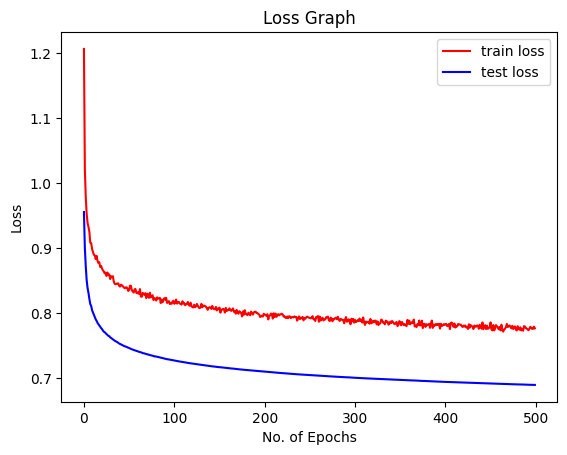

In [248]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

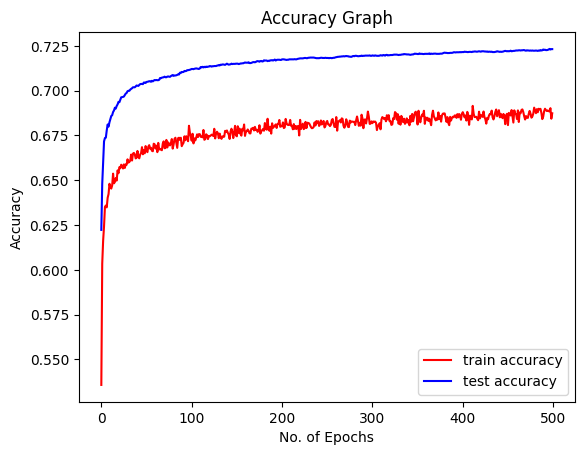

In [249]:
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();

In [255]:
best_model = models[-8]
best_model

ExtraTreesClassifier()

In [256]:
avg_cv_scores = cross_val_score(best_model,final_X_test,y_test,scoring='accuracy',cv=RepeatedKFold(n_repeats=3,n_splits=4),verbose=2)
mean_score = round(np.mean(avg_cv_scores),4)
print(f"Mean Cross Validation Performance of Extra Trees Classifier: {mean_score*100}%")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   0.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] END .................................................... total time=   0.7s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.9s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
Mean Cross Validation Performance of Extra Trees Classifier: 88.28%


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.0s finished


## Saving the best performing model for deployment into production

In [258]:
joblib.dump(best_model,'model.pkl')

['model.pkl']

In [259]:
model = joblib.load('model.pkl')
model

ExtraTreesClassifier()

In [260]:
joblib.dump(scaler,'scaler.pkl')

['scaler.pkl']

In [262]:
scaler = joblib.load('scaler.pkl')
scaler

StandardScaler()

In [263]:
joblib.dump(encoder,'label_encoder.pkl')

['label_encoder.pkl']

In [264]:
label_encoder = joblib.load('label_encoder.pkl')
label_encoder

LabelEncoder()

In [265]:
del model
del scaler
del label_encoder
gc.collect()

10830

In [267]:
for col in final_X_train.columns:
    print(f"Minimum value of {col}:",X[col].min())
    print(f"Maximum value of {col}:",X[col].max())

Minimum value of Temp_C: -23.3
Maximum value of Temp_C: 33.0
Minimum value of Press_kPa: 99.015
Maximum value of Press_kPa: 103.135
Minimum value of Rel Hum_%: 18
Maximum value of Rel Hum_%: 100
Minimum value of Wind Speed_km/h: 0.0
Maximum value of Wind Speed_km/h: 36.5
Minimum value of Visibility_km: 22.750000000000004
Maximum value of Visibility_km: 26.349999999999998
Minimum value of Hour: 0
Maximum value of Hour: 23


In [268]:
final_X_train.columns

Index(['Temp_C', 'Press_kPa', 'Rel Hum_%', 'Wind Speed_km/h', 'Visibility_km',
       'Hour'],
      dtype='object')

In [269]:
encoder.classes_

array(['Clear', 'Cloudy', 'Drizzle', 'Fog', 'Haze', 'Rain', 'Snow',
       'Thunderstorms'], dtype=object)

In [270]:
label_mapping

{'Clear': 0,
 'Cloudy': 1,
 'Drizzle': 2,
 'Fog': 3,
 'Haze': 4,
 'Rain': 5,
 'Snow': 6,
 'Thunderstorms': 7}